In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

In [2]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [27]:
# This is WRONG
# def discrete_sine_transform(y):
#     n = y.shape[0] +1
#     y_extended = jnp.concatenate([y, jnp.array([0]), -y[::-1]])
#     y_fft = fft.rfft(y_extended)
#     return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1]

def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))

In [4]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [5]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

In our case we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}

Our solution will be found using a NN.


In [42]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    # The frequency starts at 0
    frequencies = jnp.arange(0, c.shape[0])
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [43]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [44]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**13
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
print(n_coef)

frequencies = jnp.arange(0, n_coef)
coef_f = jnp.hstack([0.0, random.normal(key, shape= (n_coef-1,))]) # We set the first coefficient to zero as it corresponds to the constant term
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

8192


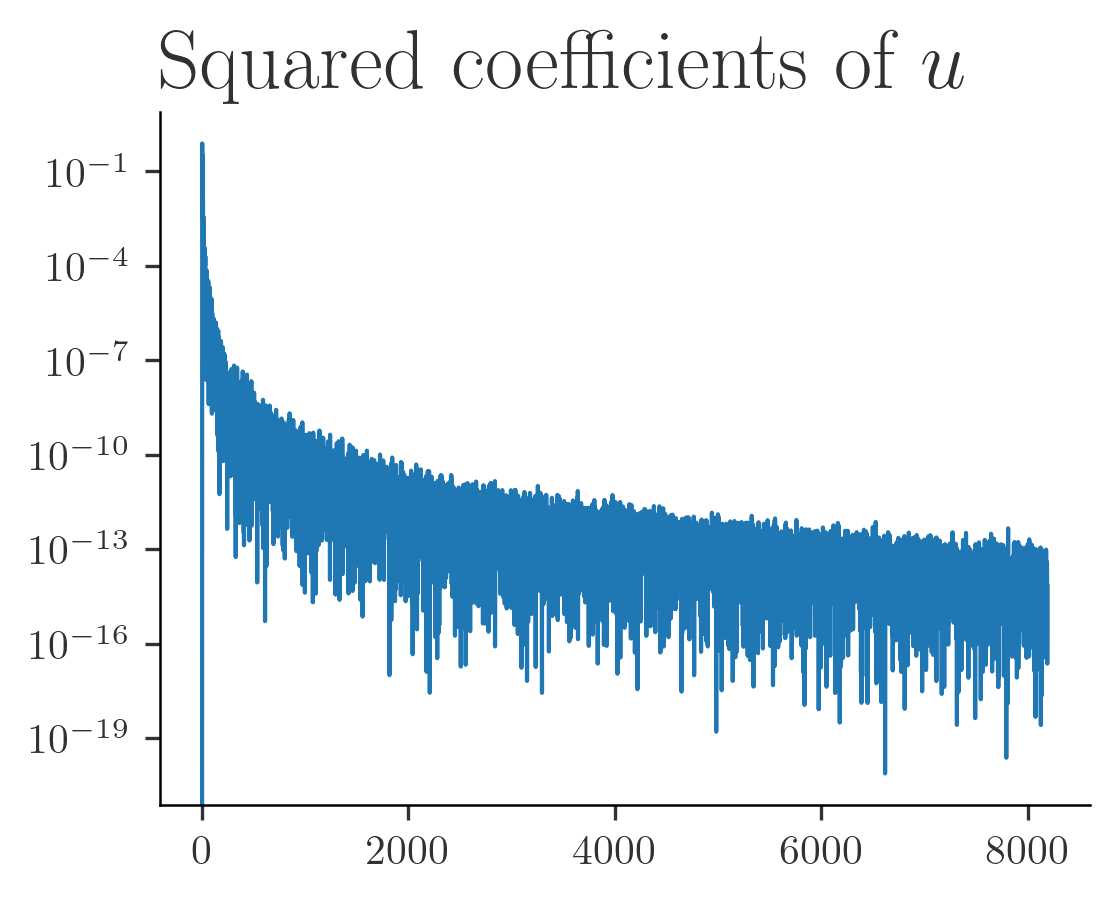

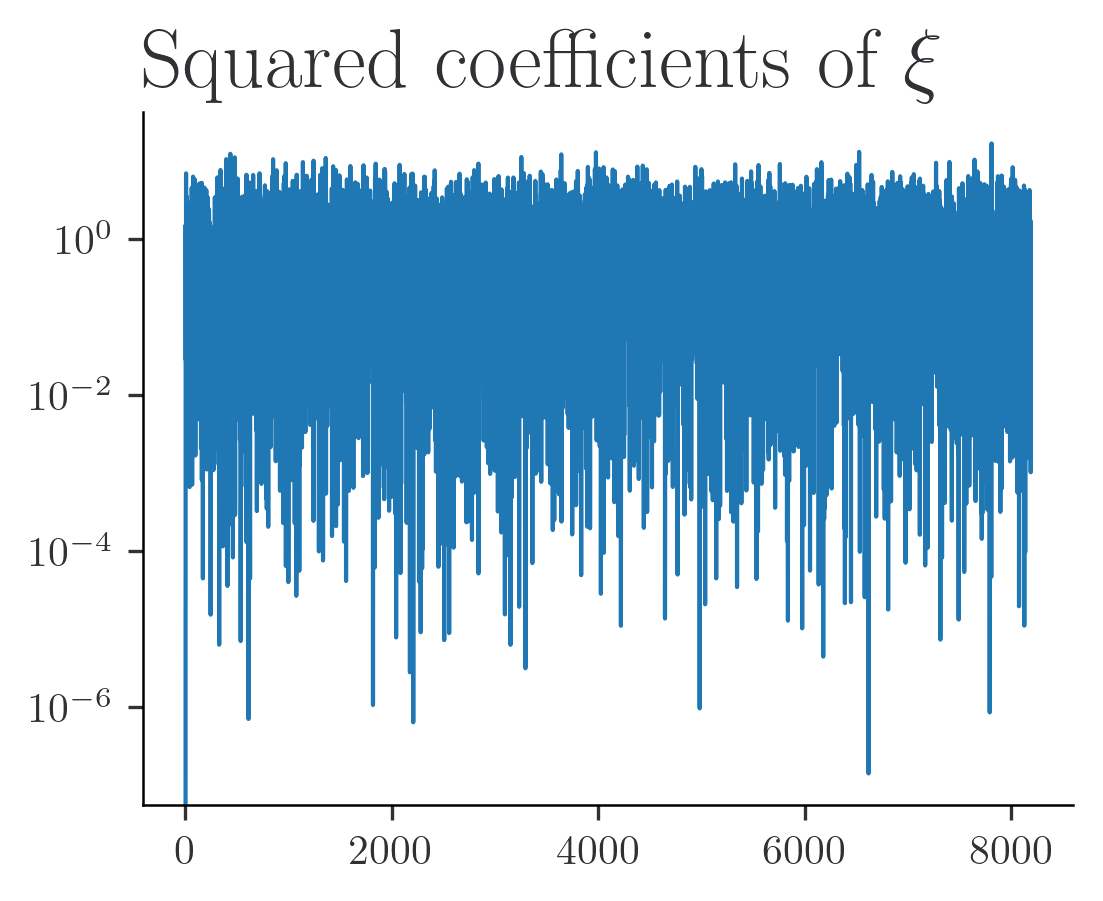

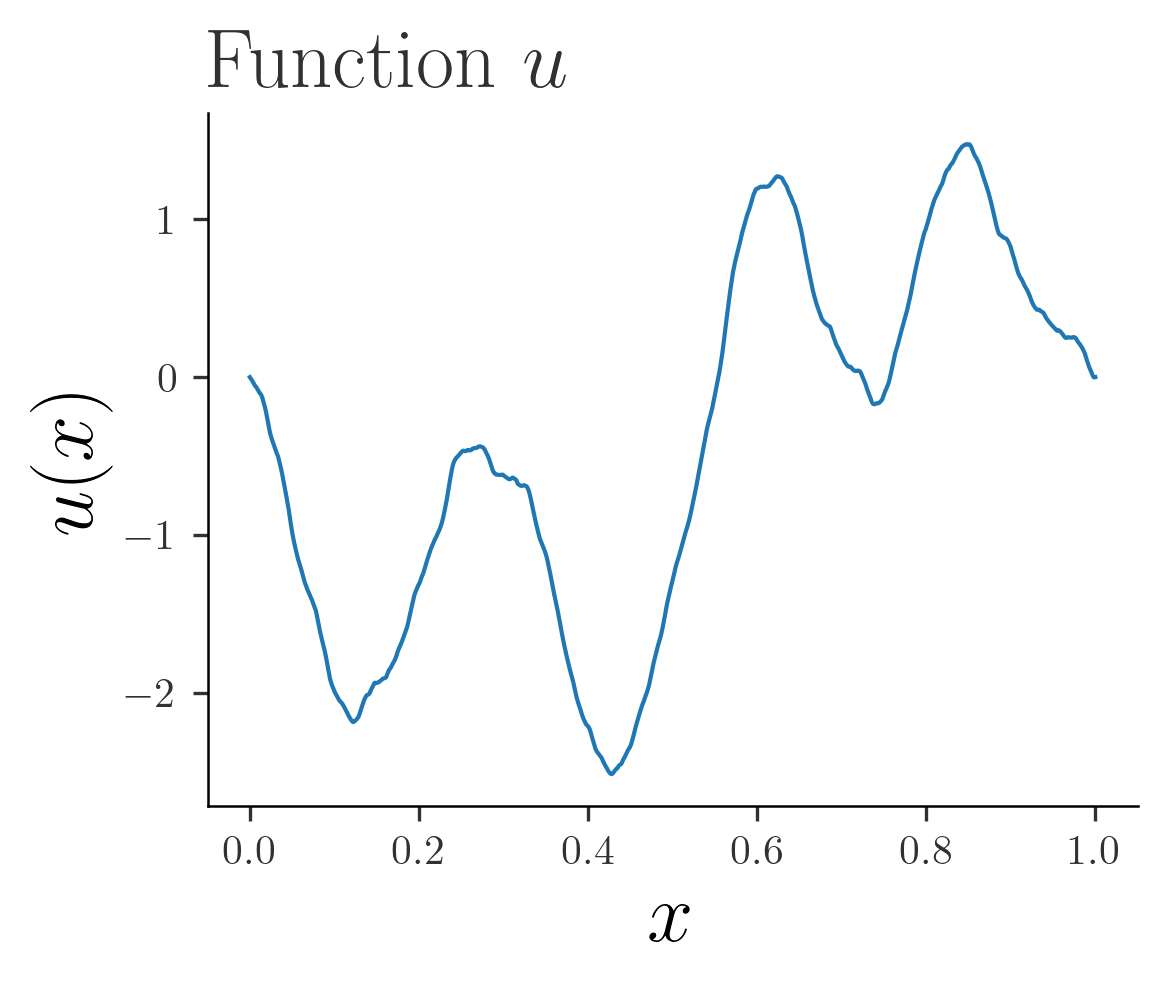

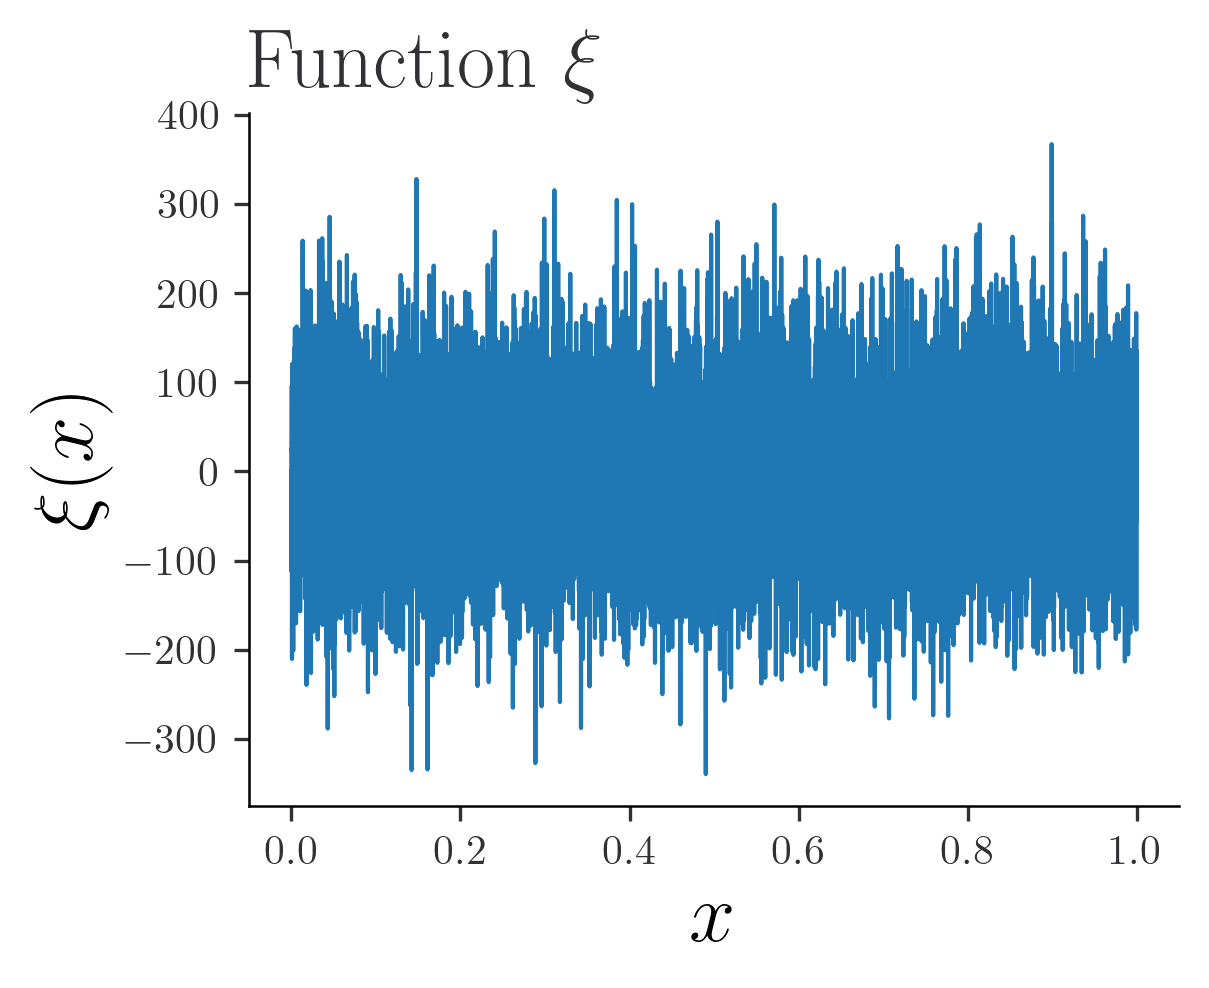

In [45]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

## We compute the accuracy of the DST

In [48]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [53]:
# We observe good recovery of u, not so good of f (which is expected)
, jnp.mean(jnp.abs(f_transform[:-1] - coef_f))jnp.mean(jnp.abs(u_transform[:-1] - coef_u))

(Array(1.40867474e-06, dtype=float64), Array(0.50384932, dtype=float64))

In [59]:
u_transform[:-1]

Array([-0.00000000e+00, -4.66567208e-01, -8.81588309e-01, ...,
        5.38297270e-11, -4.44830745e-12,  2.33205833e-11], dtype=float64)

In [61]:
coef_u

Array([ 0.00000000e+00, -4.66405723e-01, -8.81663398e-01, ...,
        4.84041776e-09, -3.80672092e-08,  8.17818791e-08], dtype=float64)

In [62]:
f_transform[:-1]

Array([-0.00000000e+00, -5.12642382e-01, -1.22967513e+00, ...,
        1.49443513e-04, -1.52048647e-04,  8.54336758e-05], dtype=float64)

In [63]:
coef_f

Array([ 0.        , -0.51243812, -1.22973016, ...,  0.03203645,
       -0.25201051,  0.54154026], dtype=float64)

In [58]:
jnp.mean(jnp.abs((u_transform[:-1] - coef_u)[1:]/coef_u[1:])), jnp.mean(jnp.abs((f_transform[:-1] - coef_f)[1:]/coef_f[1:]))

(Array(1.75745474, dtype=float64), Array(1.73200645, dtype=float64))

# PINN 4096 measurements (unweighted norm)

In [89]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas, endpoint=False)
domain_measurements.shape

4096


(4096,)

In [70]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[:-1]
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [71]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.238688707866889 [(Array([[ 7.24574418e-02,  1.10333040e-03,  5.60644339e-03,
         4.88031284e-03,  1.76052794e-02, -1.34692286e-03,
        -2.47787014e-02,  1.56824254e-01,  3.48747916e-02,
         3.12974536e-04, -1.35722414e-01,  8.45270352e-02,
        -1.06739756e-02,  7.66892146e-04,  4.09533367e-02,
         1.66374899e-02, -5.21730652e-02,  1.39994205e-01,
        -1.26964466e-01,  1.33462721e-04,  8.44228365e-02,
        -3.72099003e-02,  2.25665579e-02, -1.29233642e-01,
        -6.99036308e-03, -2.27474072e-02, -8.09901818e-03,
        -4.32722360e-02, -9.86739453e-02,  8.27282723e-02,
         6.34153204e-02,  9.19496517e-02, -8.30948336e-03,
        -6.32979041e-03, -3.06176152e-03, -7.45184800e-03,
        -3.92596254e-03, -1.25717526e-03, -2.25648743e-02,
        -1.36069039e-02, -6.70460161e-03,  4.41994132e-03,
         1.64488578e-03, -1.29479686e-02,  8.32853204e-04,
         7.44962994e-03, -1.86577631e-02, -1.28296902e-02,
         1.512

In [73]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [74]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [75]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1.2386887
Epoch 10000, Loss: 0.9766793
Epoch 20000, Loss: 0.9649323
Epoch 30000, Loss: 0.9516000
Epoch 40000, Loss: 0.9434237
Epoch 50000, Loss: 0.9323079
Epoch 60000, Loss: 0.9283527
Epoch 70000, Loss: 0.9251044
Epoch 80000, Loss: 0.9219850
Epoch 90000, Loss: 0.9184807
Epoch 100000, Loss: 0.9149716
Epoch 110000, Loss: 0.9132602
Epoch 120000, Loss: 0.9116394
Epoch 130000, Loss: 0.9103891
Epoch 140000, Loss: 0.9092837
Epoch 150000, Loss: 0.9074654
Epoch 160000, Loss: 0.9057170
Epoch 170000, Loss: 0.9049667
Epoch 180000, Loss: 0.9025856
Epoch 190000, Loss: 0.9016926
Epoch 200000, Loss: 0.9012797
Epoch 210000, Loss: 0.9009528
Early stopping at epoch 218280


In [76]:
pred = neural_network(params, domain_finest)

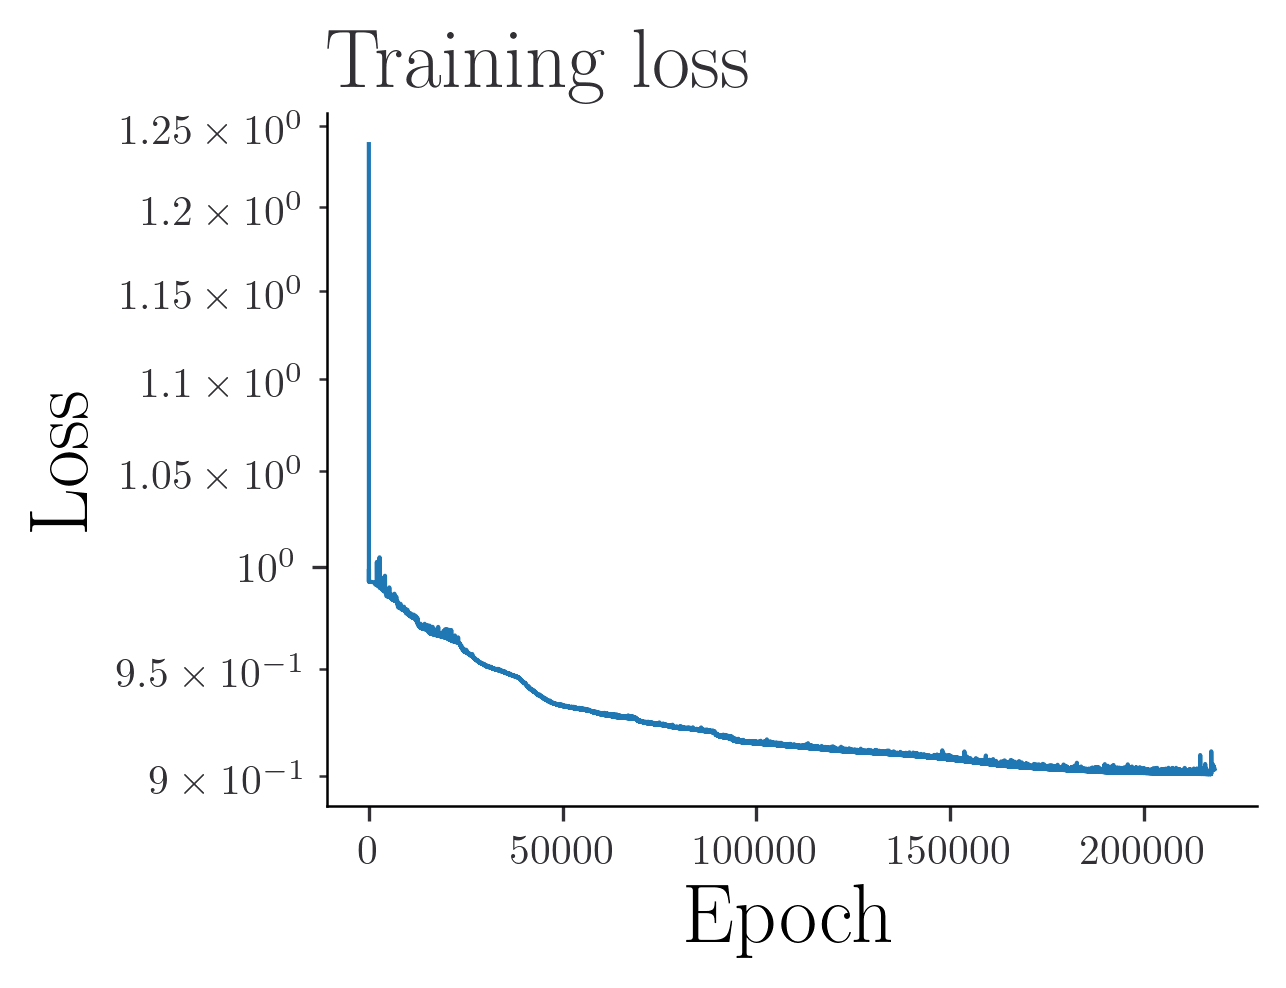

In [77]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

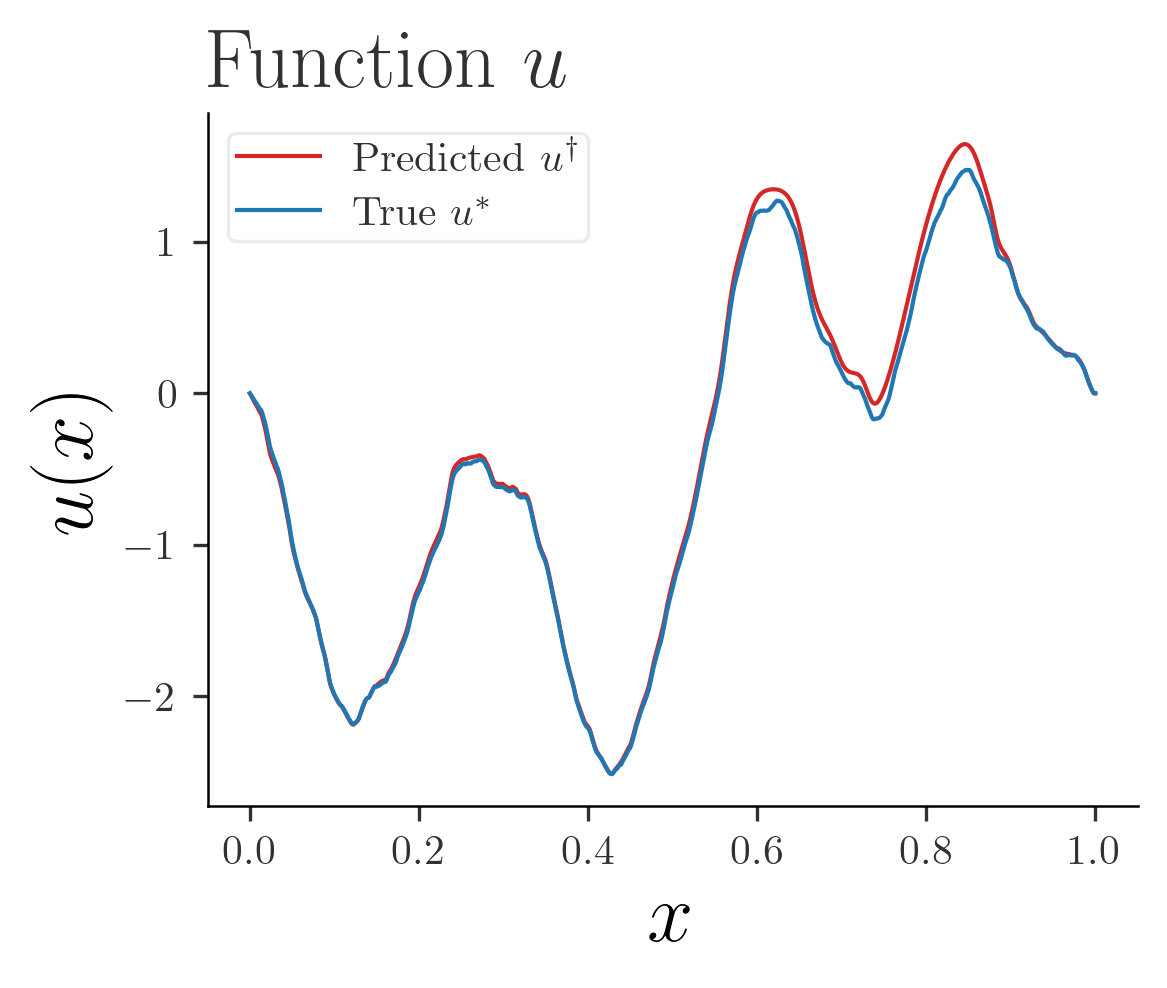

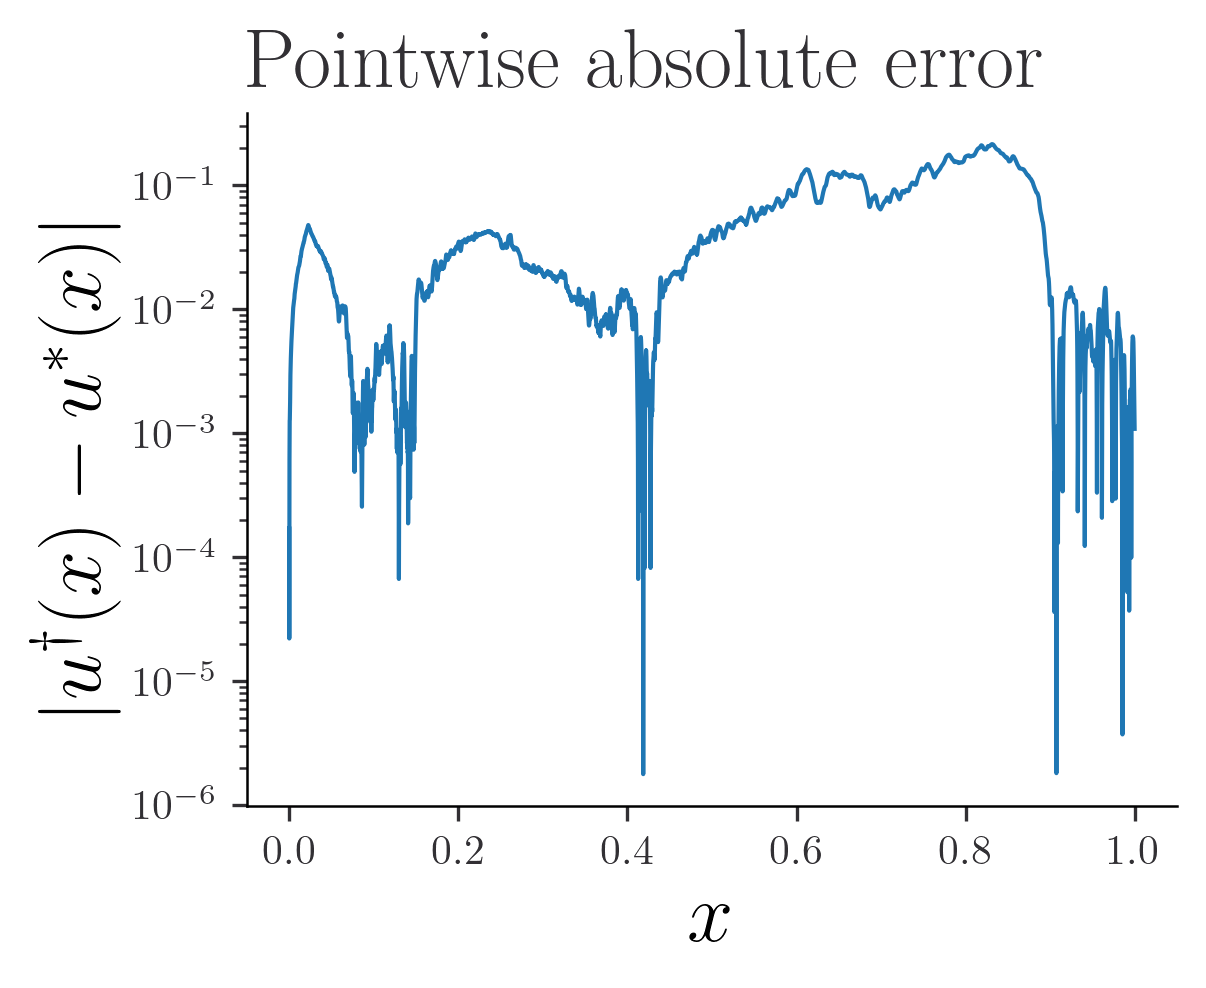

In [78]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [79]:
pred_transform = discrete_sine_transform(pred)[:-1]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


0.07632485671201777 0.061797685122585974


In [80]:
# THis computes the relative error in the coefficients that are observed
jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas])

Array(0.07632485, dtype=float64)

In [81]:
# This number should be similar to the previous (for sanity check)
jnp.sqrt(jnp.mean((pred - u_values)**2))

Array(0.07654667, dtype=float64)

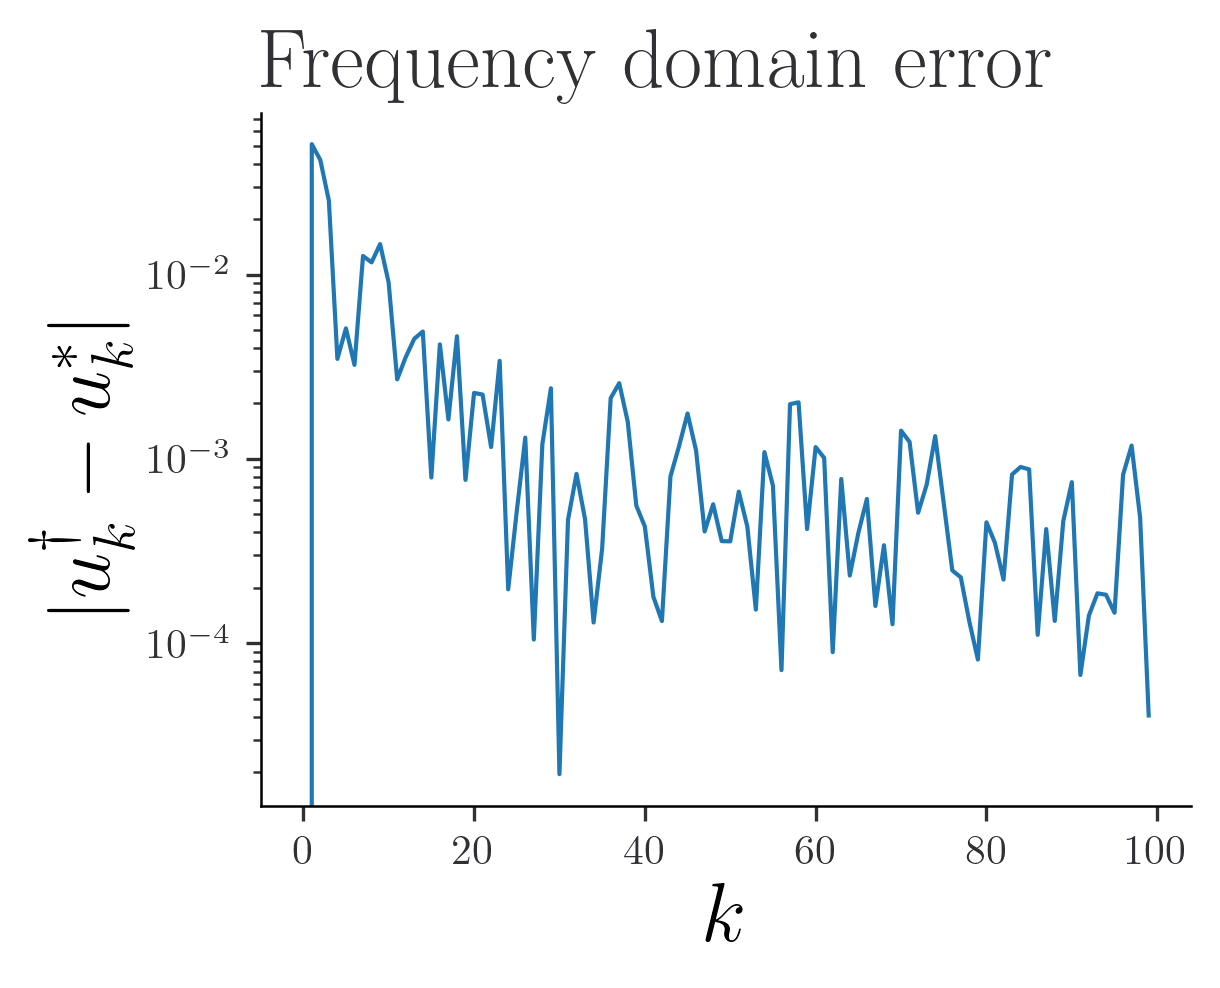

In [82]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

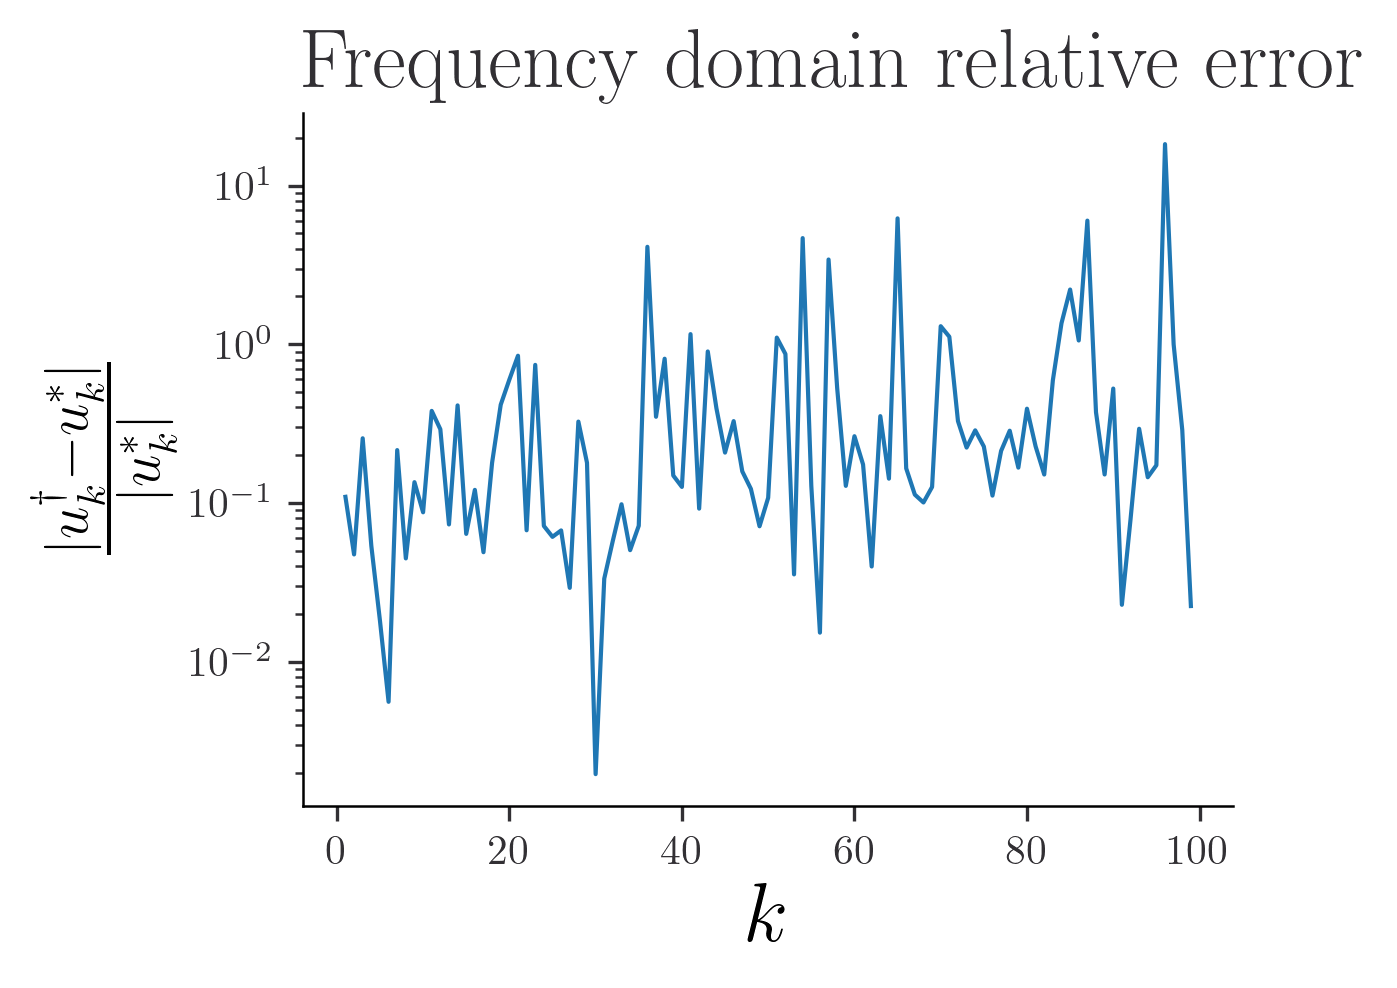

In [83]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements ($H^{-1/2}$ weighted norm)

In [151]:
nugget = jnp.arange(1, n_meas+1)**(-0.5) # We weight the measurement according to the H^{-0.5} norm
print(nugget)

[1.         0.70710678 0.57735027 ... 0.01562882 0.01562691 0.015625  ]


In [152]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[:-1]
    residual_interior = (pred_sine - f)*nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [153]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.2476347605450377 [(Array([[ 7.24439339e-02,  1.10341329e-03,  5.60116896e-03,
         4.87194434e-03,  1.76013576e-02, -1.34712347e-03,
        -2.47638101e-02,  1.56814261e-01,  3.48632745e-02,
         3.11256028e-04, -1.35705328e-01,  8.45253061e-02,
        -1.06723783e-02,  7.55631939e-04,  4.09481947e-02,
         1.66278760e-02, -5.21662453e-02,  1.39977215e-01,
        -1.26944855e-01,  1.36512466e-04,  8.44151519e-02,
        -3.72080600e-02,  2.25676708e-02, -1.29223090e-01,
        -6.99202975e-03, -2.27405818e-02, -8.09228050e-03,
        -4.32667434e-02, -9.86580926e-02,  8.27153297e-02,
         6.34032862e-02,  9.19416241e-02, -8.29479686e-03,
        -6.32066255e-03, -3.06284899e-03, -7.44507395e-03,
        -3.92603058e-03, -1.25091013e-03, -2.25524344e-02,
        -1.36017516e-02, -6.70315370e-03,  4.41609669e-03,
         1.64787695e-03, -1.29464200e-02,  8.28372687e-04,
         7.44507282e-03, -1.86640424e-02, -1.28263116e-02,
         1.54

In [154]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [155]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [156]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [157]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.2476348
Epoch 10000, Loss: 0.0016863
Epoch 20000, Loss: 0.0016338
Epoch 30000, Loss: 0.0013356
Epoch 40000, Loss: 0.0011909
Epoch 50000, Loss: 0.0011439
Epoch 60000, Loss: 0.0011122
Epoch 70000, Loss: 0.0010285
Epoch 80000, Loss: 0.0009674
Epoch 90000, Loss: 0.0008719
Epoch 100000, Loss: 0.0008368
Epoch 110000, Loss: 0.0008121
Epoch 120000, Loss: 0.0008037
Epoch 130000, Loss: 0.0007970
Epoch 140000, Loss: 0.0008549
Epoch 150000, Loss: 0.0007853
Epoch 160000, Loss: 0.0007844
Epoch 170000, Loss: 0.0007895
Epoch 180000, Loss: 0.0007749
Epoch 190000, Loss: 0.0007704
Epoch 200000, Loss: 0.0007680
Epoch 210000, Loss: 0.0008377
Epoch 220000, Loss: 0.0007703
Epoch 230000, Loss: 0.0007653
Epoch 240000, Loss: 0.0007647
Epoch 250000, Loss: 0.0007760
Epoch 260000, Loss: 0.0007627
Epoch 270000, Loss: 0.0007669
Epoch 280000, Loss: 0.0007604
Epoch 290000, Loss: 0.0007583


In [170]:
pred = neural_network(params, domain_finest)

In [159]:
#pred = neural_network(best_param, domain_finest)

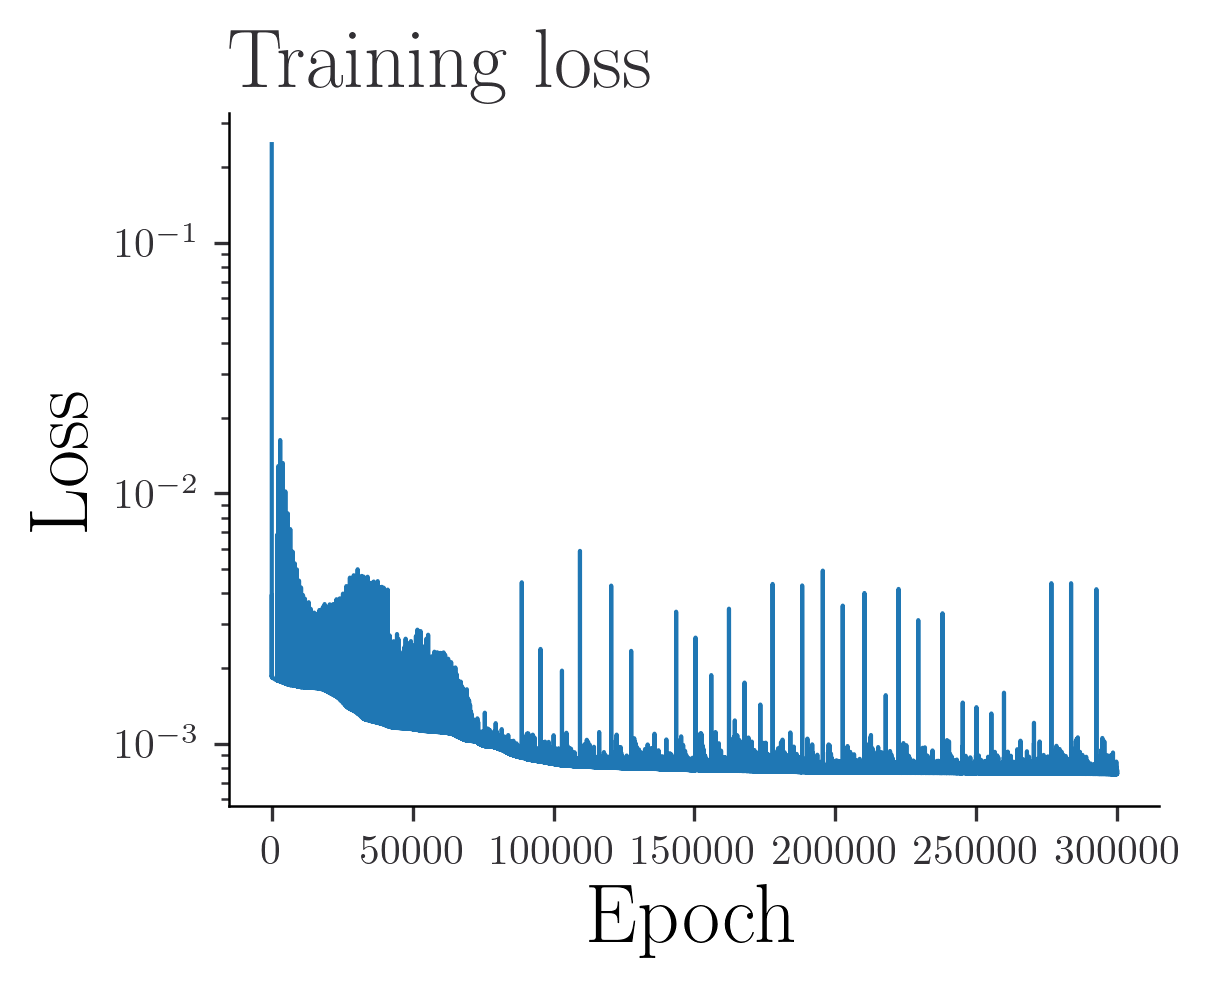

In [160]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

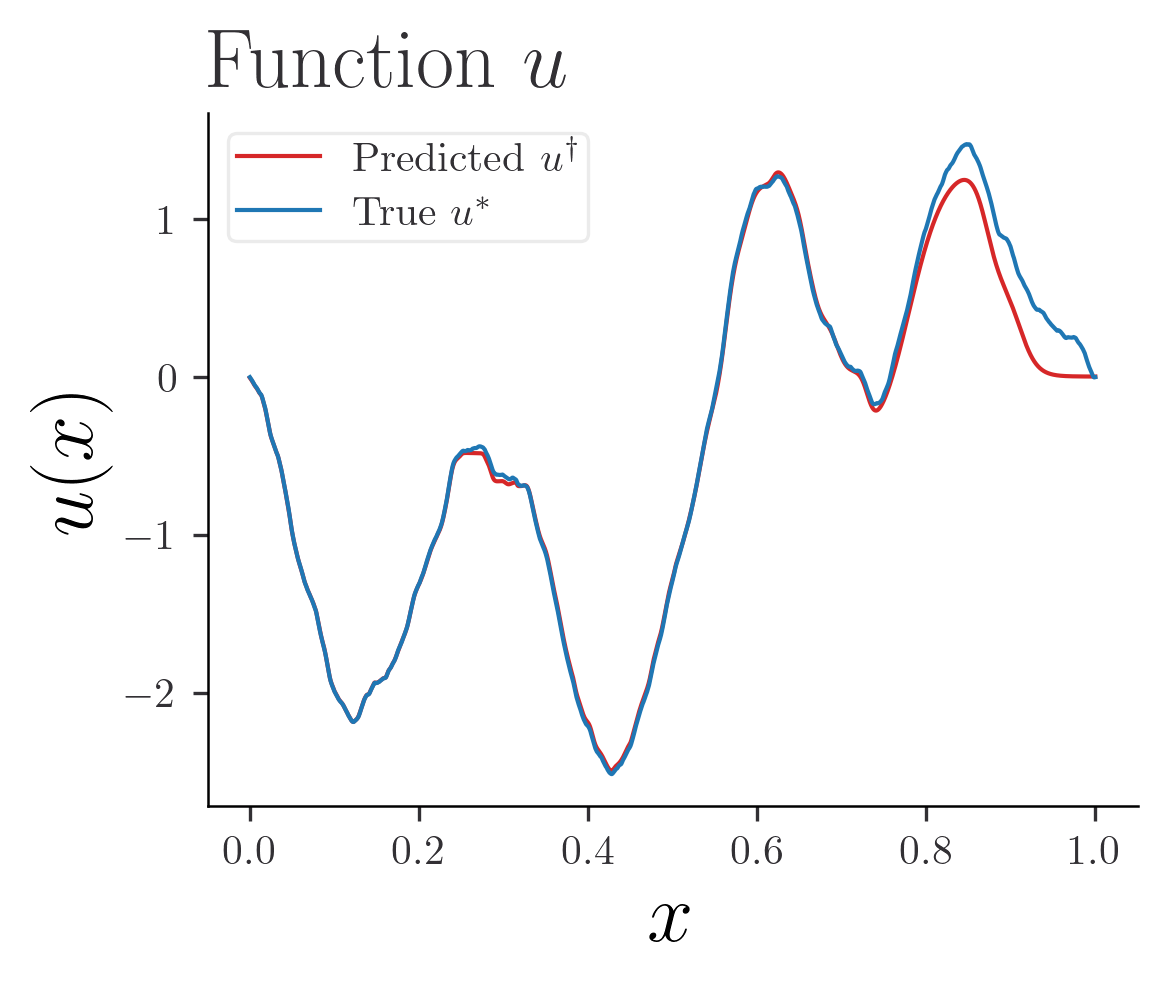

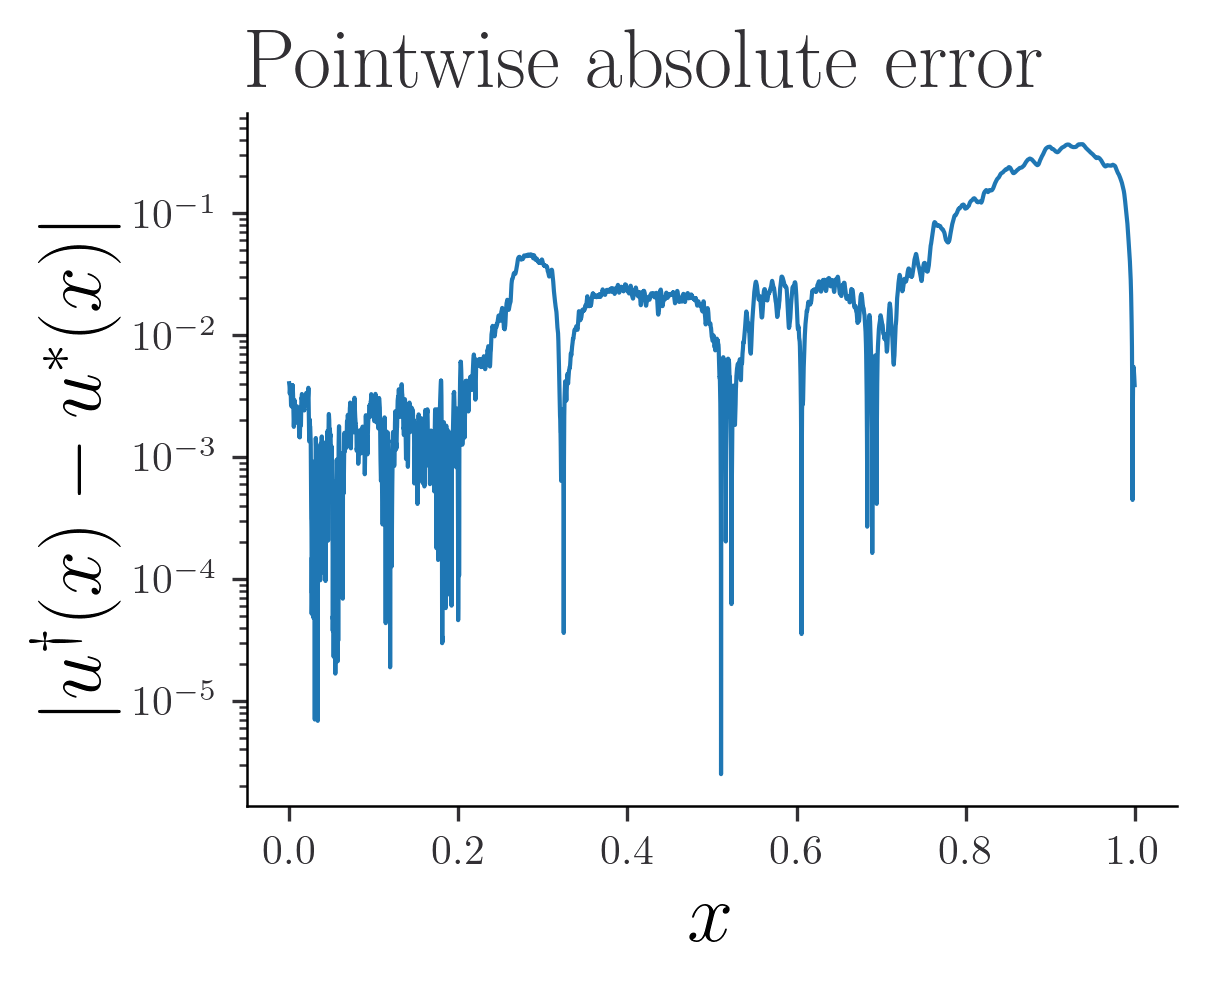

In [171]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [172]:
pred_transform = discrete_sine_transform(pred)[:-1]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


0.1172079519878932 0.09489936074351674


In [173]:
print(jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas]))
print(jnp.sqrt(jnp.mean((pred - u_values)**2)))

0.1172079492594007
0.11729779070694255


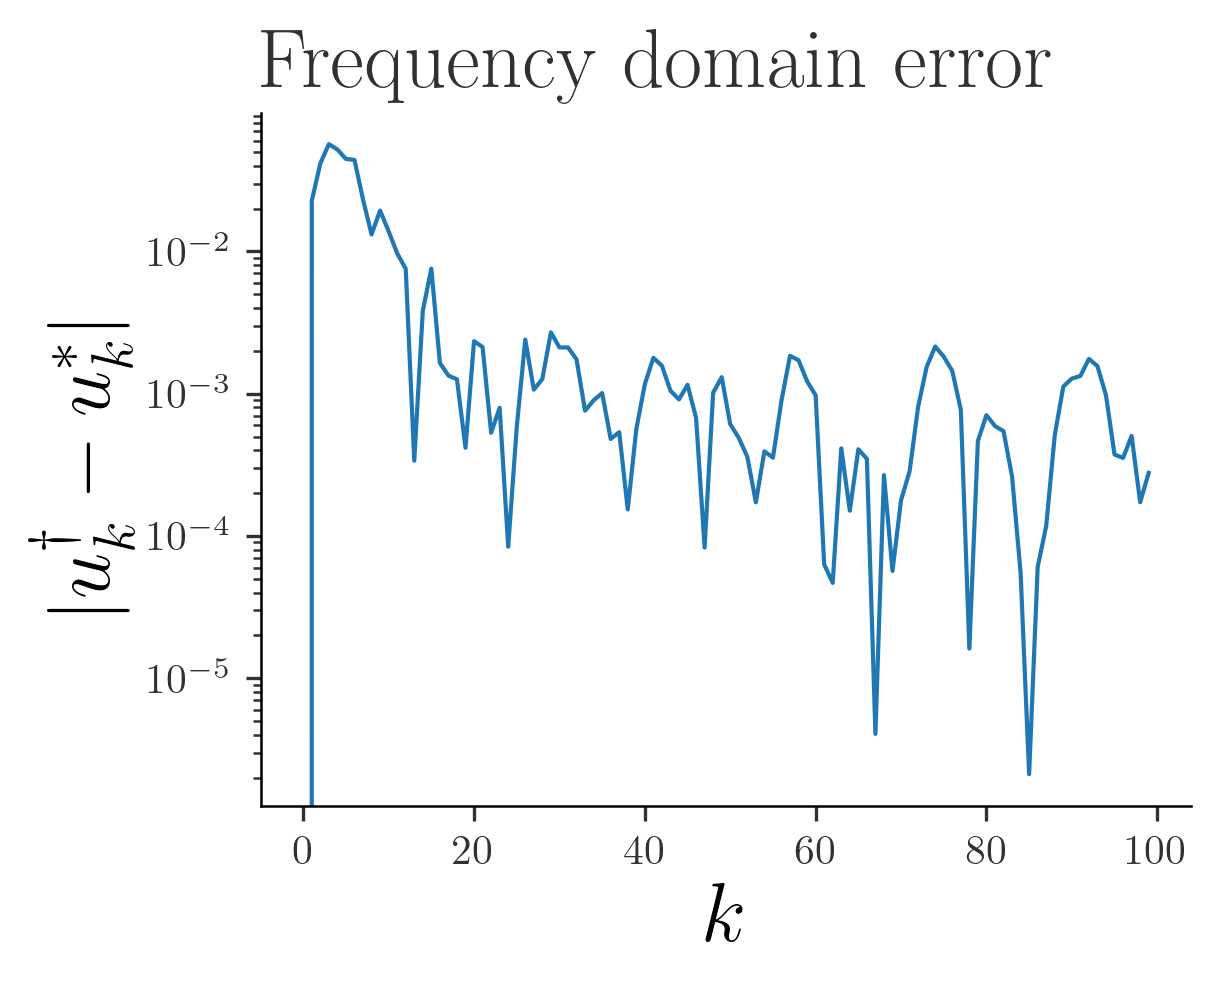

In [174]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

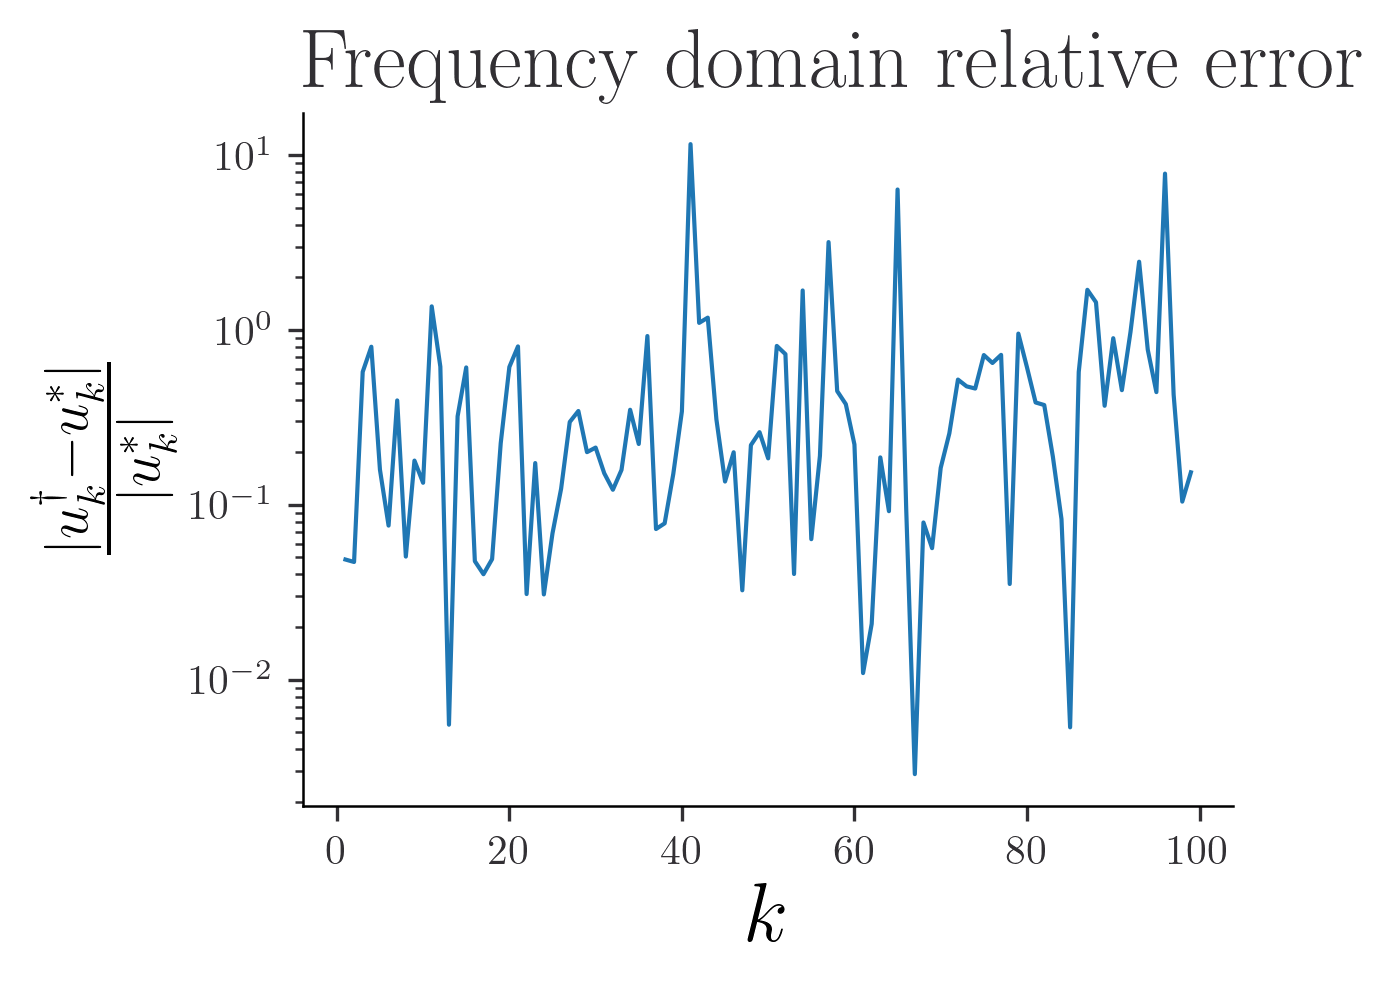

In [175]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements ($H^{-1}$ weighted norm)

In [134]:
nugget = jnp.arange(1, n_meas+1)**(-1.0) # We weight the measurement according to the H^{-1} norm
print(nugget)

[1.00000000e+00 5.00000000e-01 3.33333333e-01 ... 2.44259893e-04
 2.44200244e-04 2.44140625e-04]


In [135]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[:-1]
    residual_interior = (pred_sine - f)*nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [136]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.24588447126923454 [(Array([[ 7.24391020e-02,  1.10337225e-03,  5.59896081e-03,
         4.86859208e-03,  1.75998911e-02, -1.34669066e-03,
        -2.47572369e-02,  1.56811274e-01,  3.48586287e-02,
         3.10513739e-04, -1.35699561e-01,  8.45251598e-02,
        -1.06714936e-02,  7.51734250e-04,  4.09461756e-02,
         1.66237586e-02, -5.21641012e-02,  1.39971380e-01,
        -1.26937786e-01,  1.37440154e-04,  8.44124091e-02,
        -3.72074672e-02,  2.25683908e-02, -1.29220060e-01,
        -6.99266330e-03, -2.27379198e-02, -8.08972914e-03,
        -4.32645370e-02, -9.86518801e-02,  8.27105674e-02,
         6.33981716e-02,  9.19393251e-02, -8.28913826e-03,
        -6.31699210e-03, -3.06309705e-03, -7.44240865e-03,
        -3.92625082e-03, -1.24850179e-03, -2.25474913e-02,
        -1.35996661e-02, -6.70230695e-03,  4.41451786e-03,
         1.64919794e-03, -1.29458061e-02,  8.26698977e-04,
         7.44323034e-03, -1.86666701e-02, -1.28249805e-02,
         1.5

In [137]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [138]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [139]:
patience = 2000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [140]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.9f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.245884471
Epoch 10000, Loss: 0.000080275
Epoch 20000, Loss: 0.000078774
Epoch 30000, Loss: 0.000073742
Epoch 40000, Loss: 0.000061925
Epoch 50000, Loss: 0.000051405
Epoch 60000, Loss: 0.000045531
Epoch 70000, Loss: 0.000042099
Epoch 80000, Loss: 0.000040240
Epoch 90000, Loss: 0.000045240
Epoch 100000, Loss: 0.000038548
Epoch 110000, Loss: 0.000032443
Epoch 120000, Loss: 0.000028134
Epoch 130000, Loss: 0.000026510
Epoch 140000, Loss: 0.000101855
Epoch 150000, Loss: 0.000028216
Epoch 160000, Loss: 0.000024537
Epoch 170000, Loss: 0.000024576
Early stopping at epoch 173130


In [149]:
pred = neural_network(best_param, domain_finest)

In [141]:
pred = neural_network(params, domain_finest)

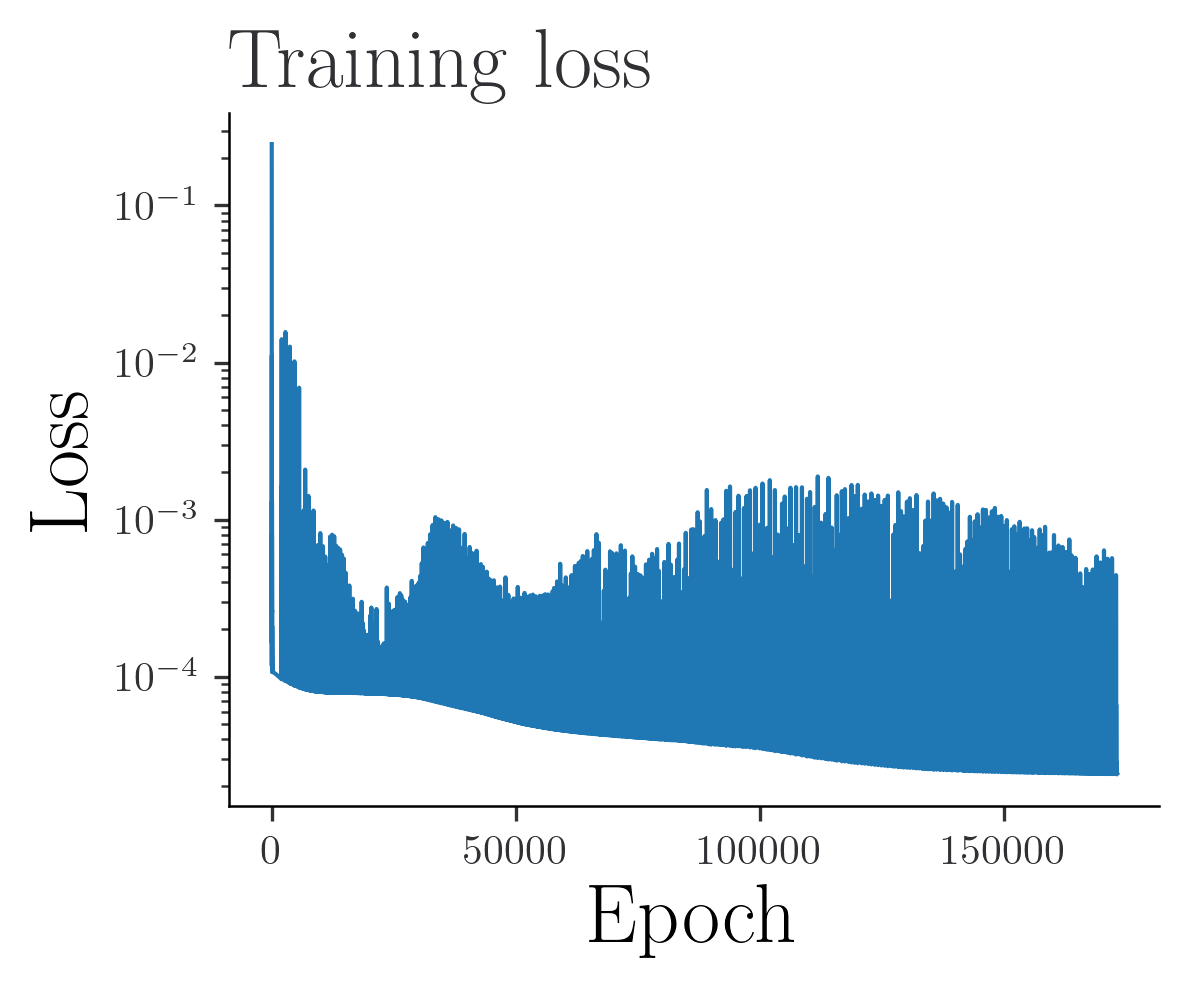

In [142]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

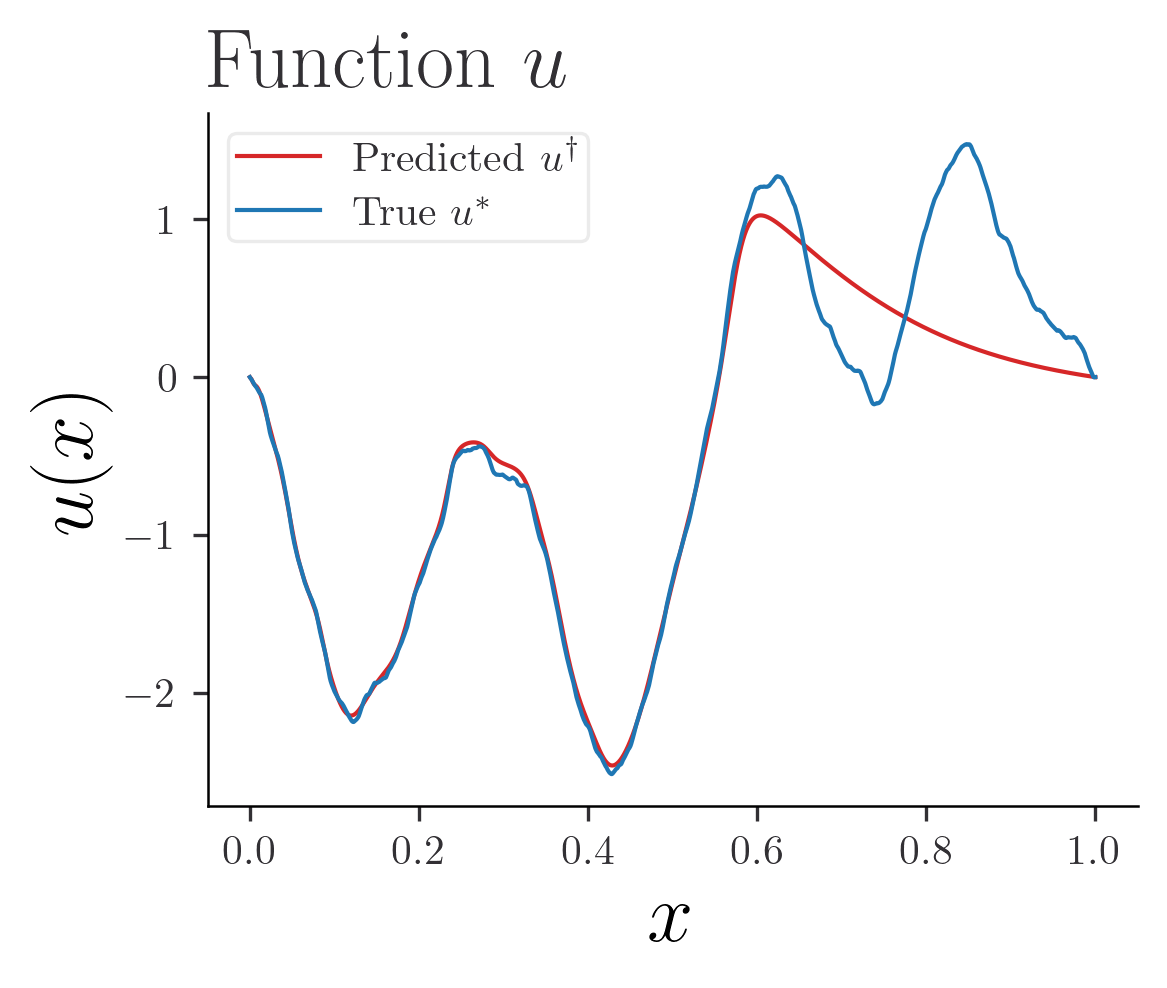

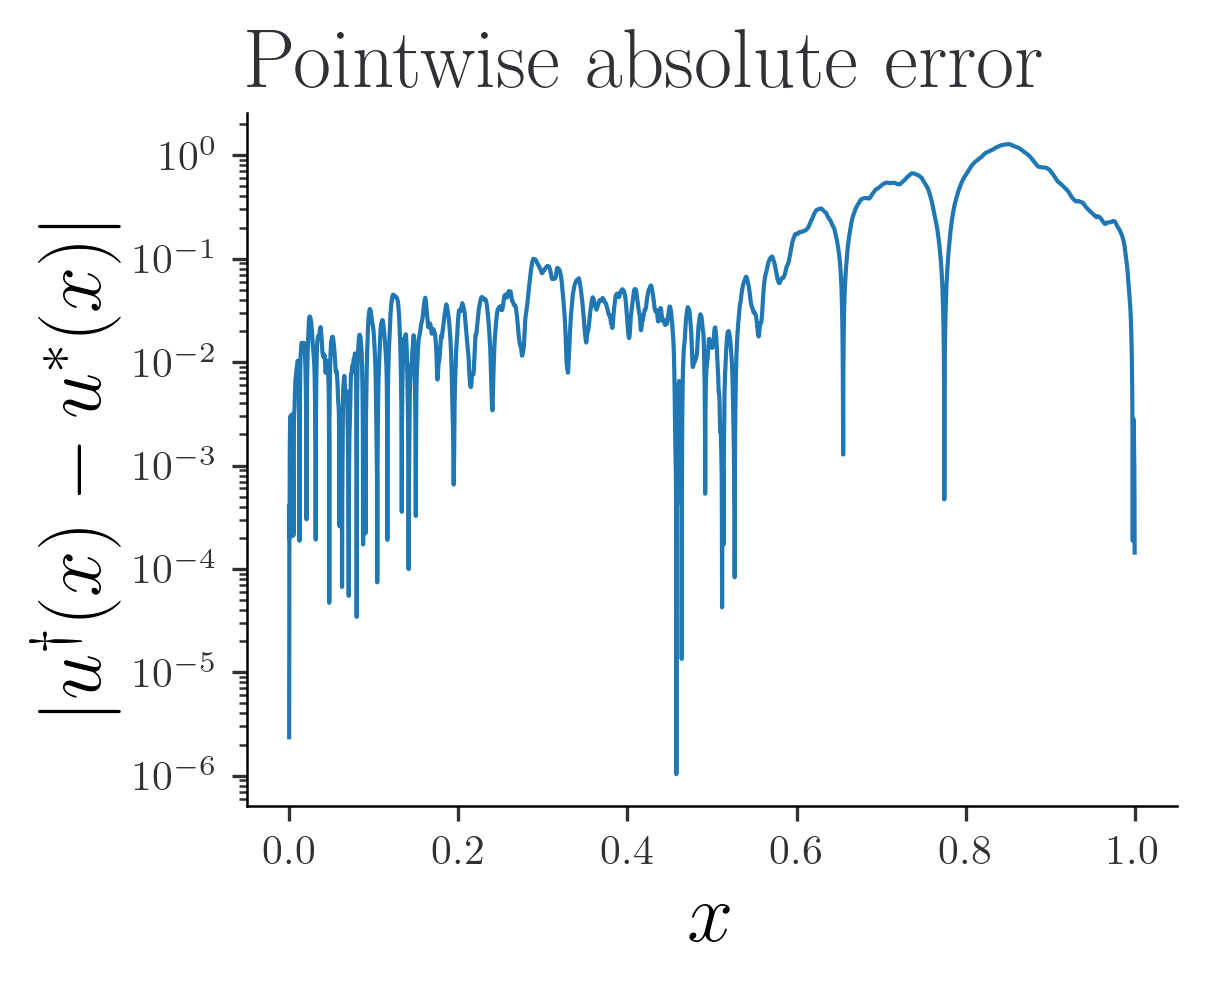

In [150]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [144]:
pred_transform = discrete_sine_transform(pred)[:-1]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

1.3140019134772056 1.0639034254060258


In [145]:
print(jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas]))
print(jnp.sqrt(jnp.mean((pred - u_values)**2)))

1.3140019133188208
0.391463572351955


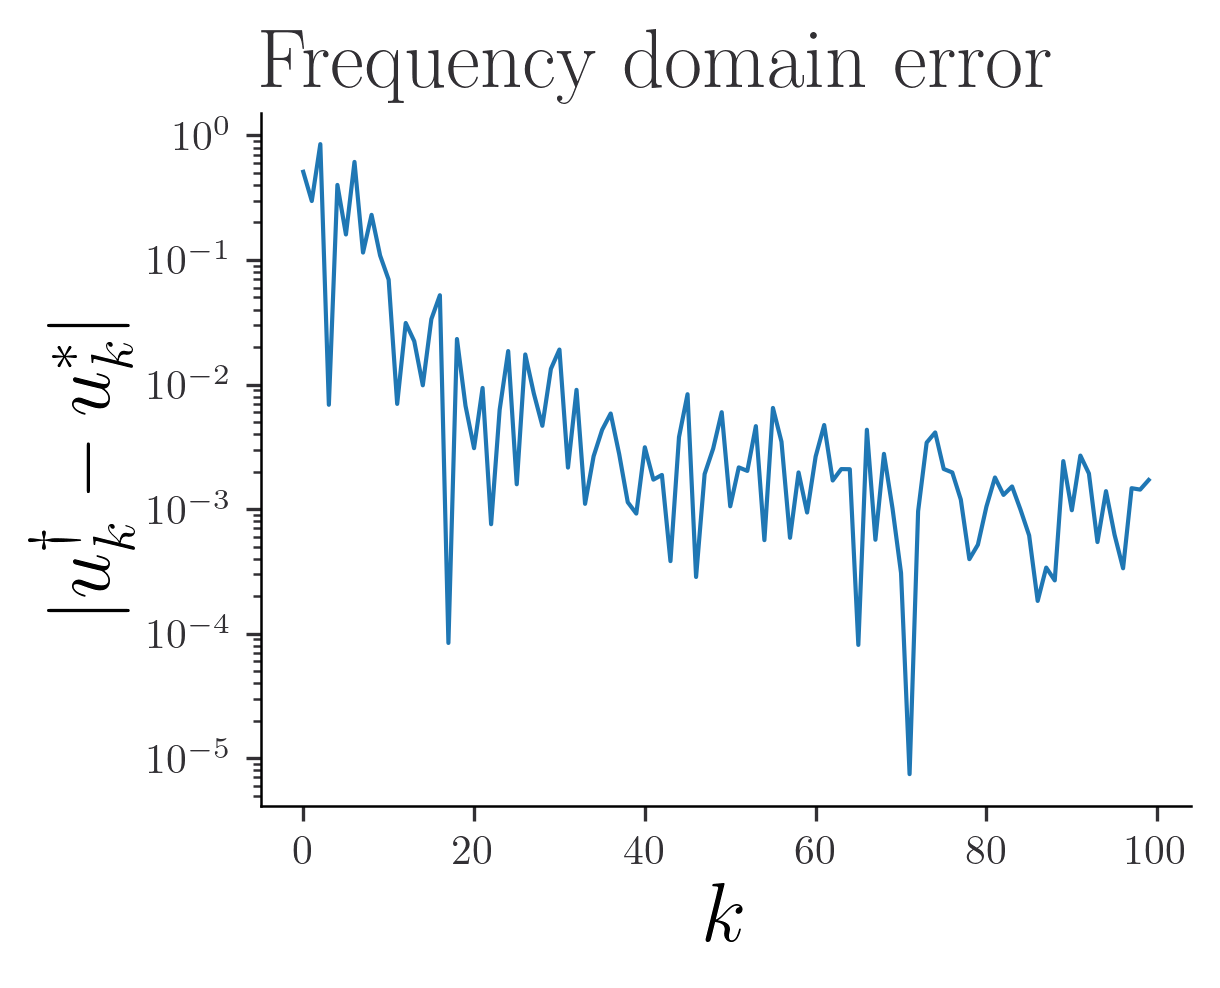

In [146]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

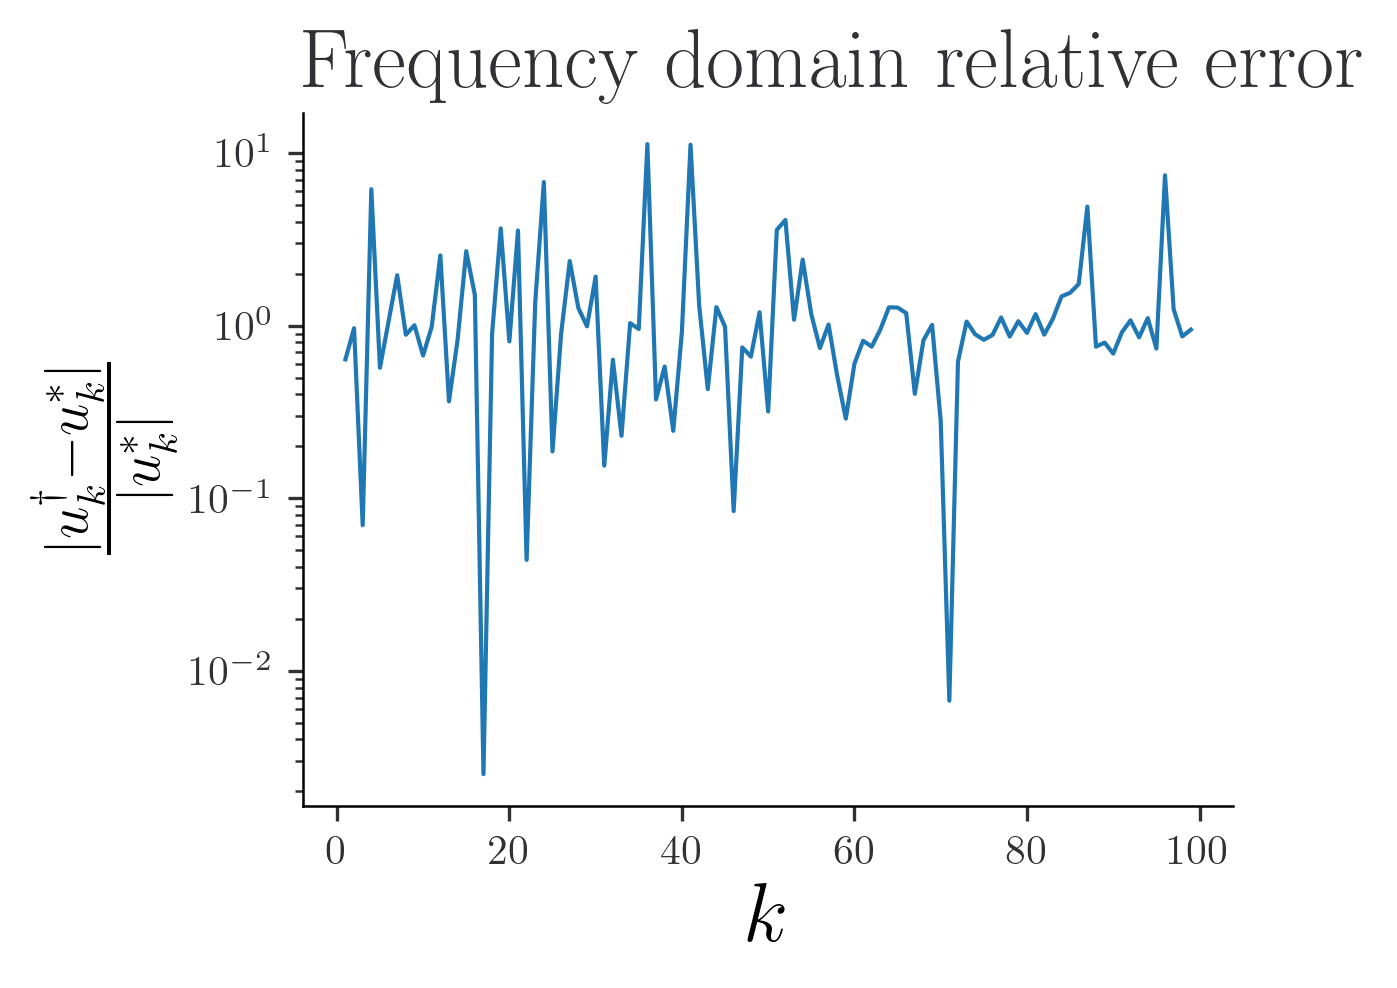

In [147]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 pointwise measurements

In [190]:
f_pointwise = evaluate_basis_sine(domain_measurements, coef_f)

print(f_pointwise.shape, domain_measurements.shape)

(4096,) (4096,)


In [191]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    residual_interior = -nu*laplacian_grid + u_grid -f #-nu*laplacian_grid + u_grid - f

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [192]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_pointwise,boundary_conditions, nu, 1.0)
print(loss, grads)

() ()
(4096,) (4096,)
8032.524353277399 [(Array([[ 3.13007767e-01,  5.33516035e-03,  6.73460484e-02,
         8.94056933e-02,  8.62380671e-02, -1.16135520e-02,
        -2.28380859e-01,  4.96590831e-01,  2.07675241e-01,
         1.63142717e-02, -4.99034212e-01,  2.32575495e-01,
        -5.35514142e-02,  8.74567061e-02,  1.61986209e-01,
         1.44534663e-01, -1.94691538e-01,  5.23720952e-01,
        -5.08117090e-01, -1.79092371e-02,  3.03436836e-01,
        -1.13406941e-01,  4.41077483e-02, -4.12722674e-01,
        -9.15469473e-03, -1.25529492e-01, -8.12526294e-02,
        -1.77953676e-01, -4.30815071e-01,  3.35298003e-01,
         3.07067996e-01,  3.01820902e-01, -1.52932951e-01,
        -1.02529959e-01, -5.42367819e-03, -8.45643190e-02,
        -7.38974724e-03, -5.58644058e-02, -1.77582192e-01,
        -9.16637283e-02, -4.20034528e-02,  5.00781324e-02,
        -2.18017826e-02, -5.24177463e-02,  4.17316419e-02,
         6.58505328e-02,  6.31185552e-03, -6.99293742e-02,
        -1.814

In [193]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [194]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_pointwise,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [195]:
patience = 2000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 8032.5243533
Epoch 10000, Loss: 7627.8786549
Epoch 20000, Loss: 7567.1258428
Epoch 30000, Loss: 7522.3184287
Epoch 40000, Loss: 7508.4213021
Epoch 50000, Loss: 7456.9270441
Epoch 60000, Loss: 7432.5908515
Epoch 70000, Loss: 7424.1248911
Epoch 80000, Loss: 7404.2612901
Epoch 90000, Loss: 7396.0231507
Epoch 100000, Loss: 7385.7631663
Epoch 110000, Loss: 7375.6025265
Epoch 120000, Loss: 7364.7779054
Epoch 130000, Loss: 7357.7521662
Epoch 140000, Loss: 7352.1127181
Epoch 150000, Loss: 7351.7347262
Epoch 160000, Loss: 7346.1042770
Epoch 170000, Loss: 7339.3450634
Epoch 180000, Loss: 7331.6797994
Epoch 190000, Loss: 7322.1207996
Epoch 200000, Loss: 7315.6478433
Epoch 210000, Loss: 7308.6495384
Epoch 220000, Loss: 7305.2054049
Epoch 230000, Loss: 7304.5028887
Epoch 240000, Loss: 7308.0935401
Epoch 250000, Loss: 7294.8782723
Epoch 260000, Loss: 7292.0600504
Epoch 270000, Loss: 7288.3845712
Epoch 280000, Loss: 7288.3370040
Epoch 290000, Loss: 7285.3186844


In [196]:
pred = neural_network(params, domain_finest)

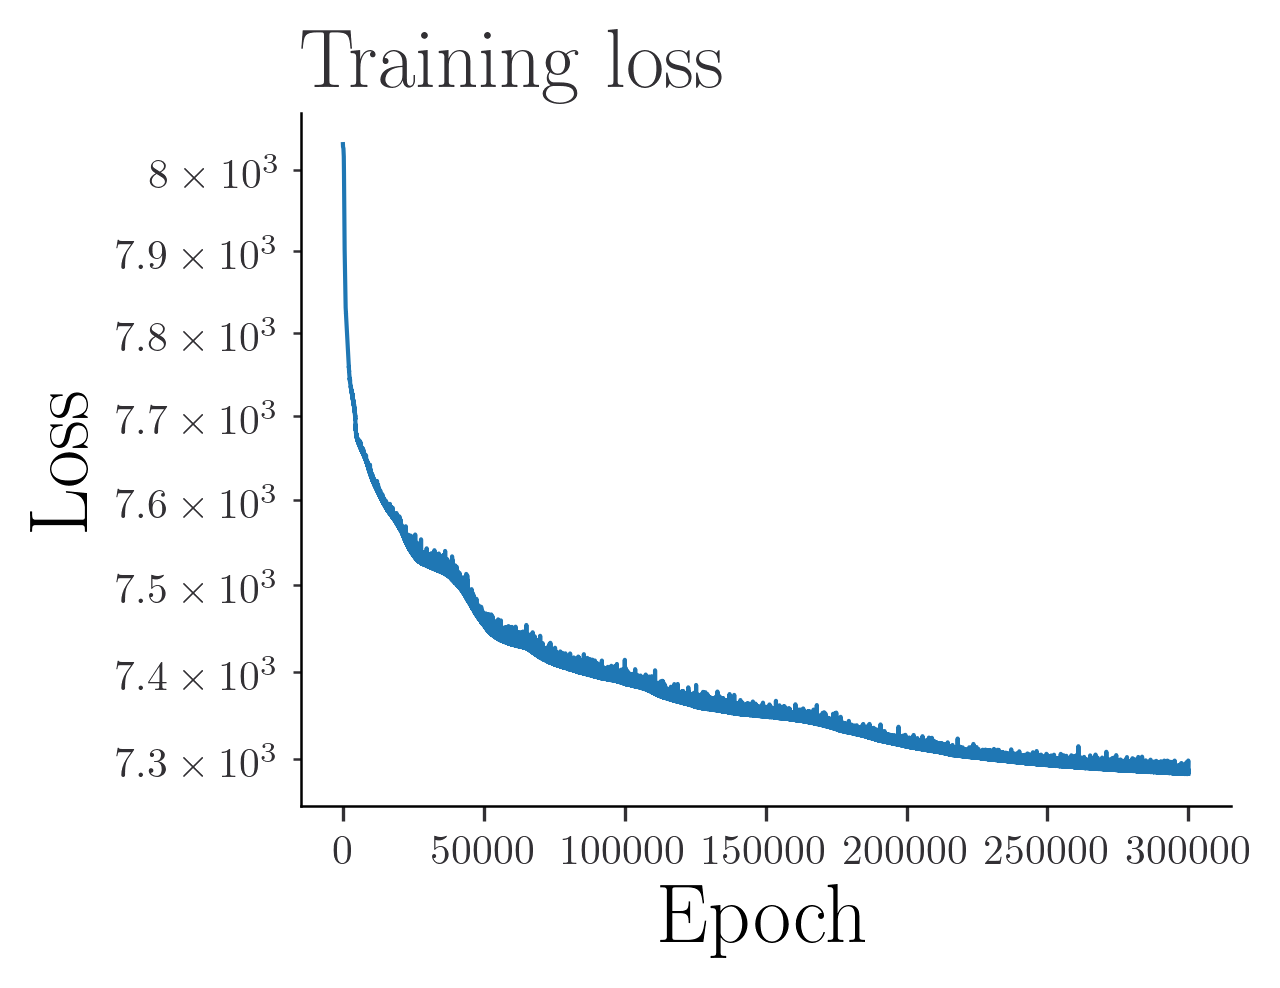

In [197]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

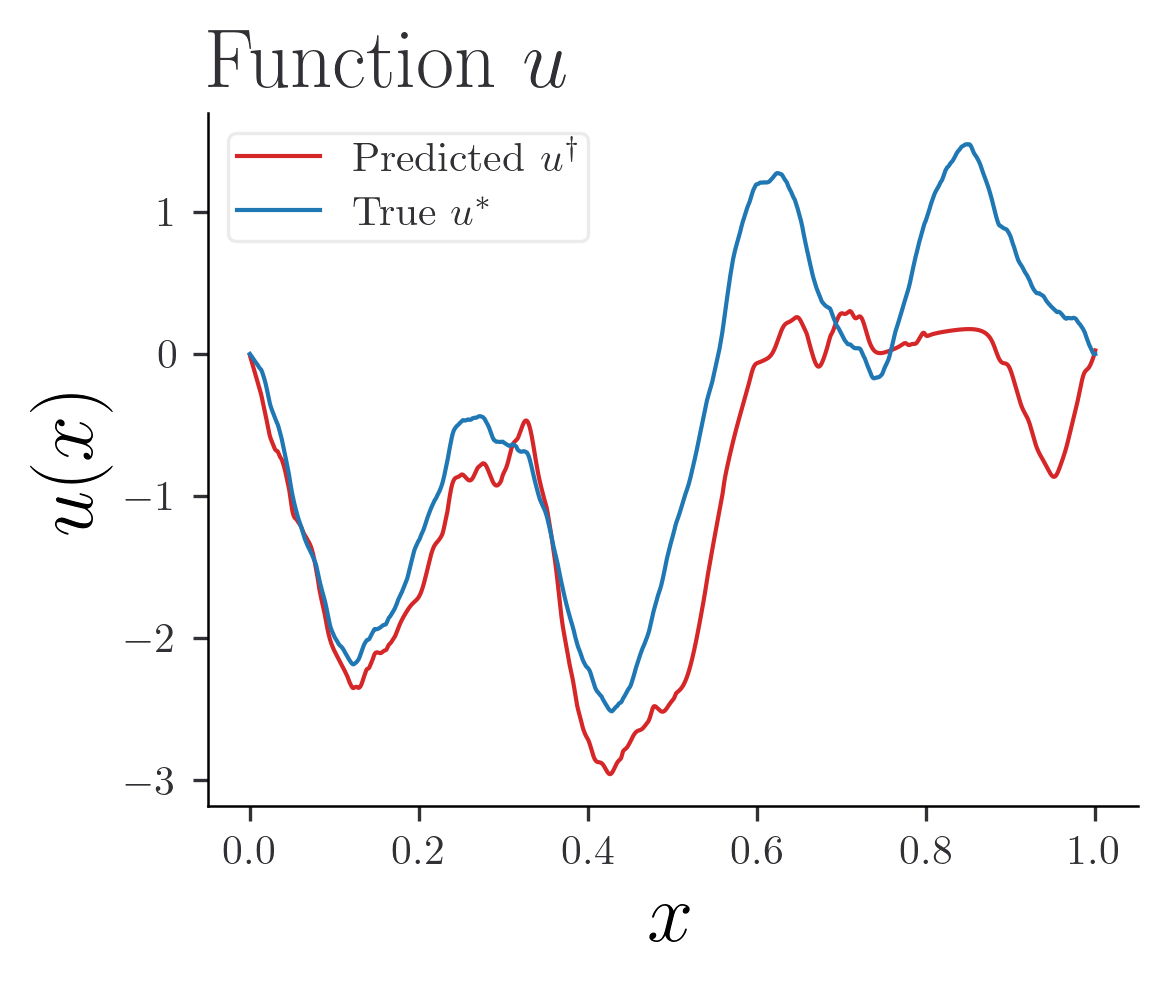

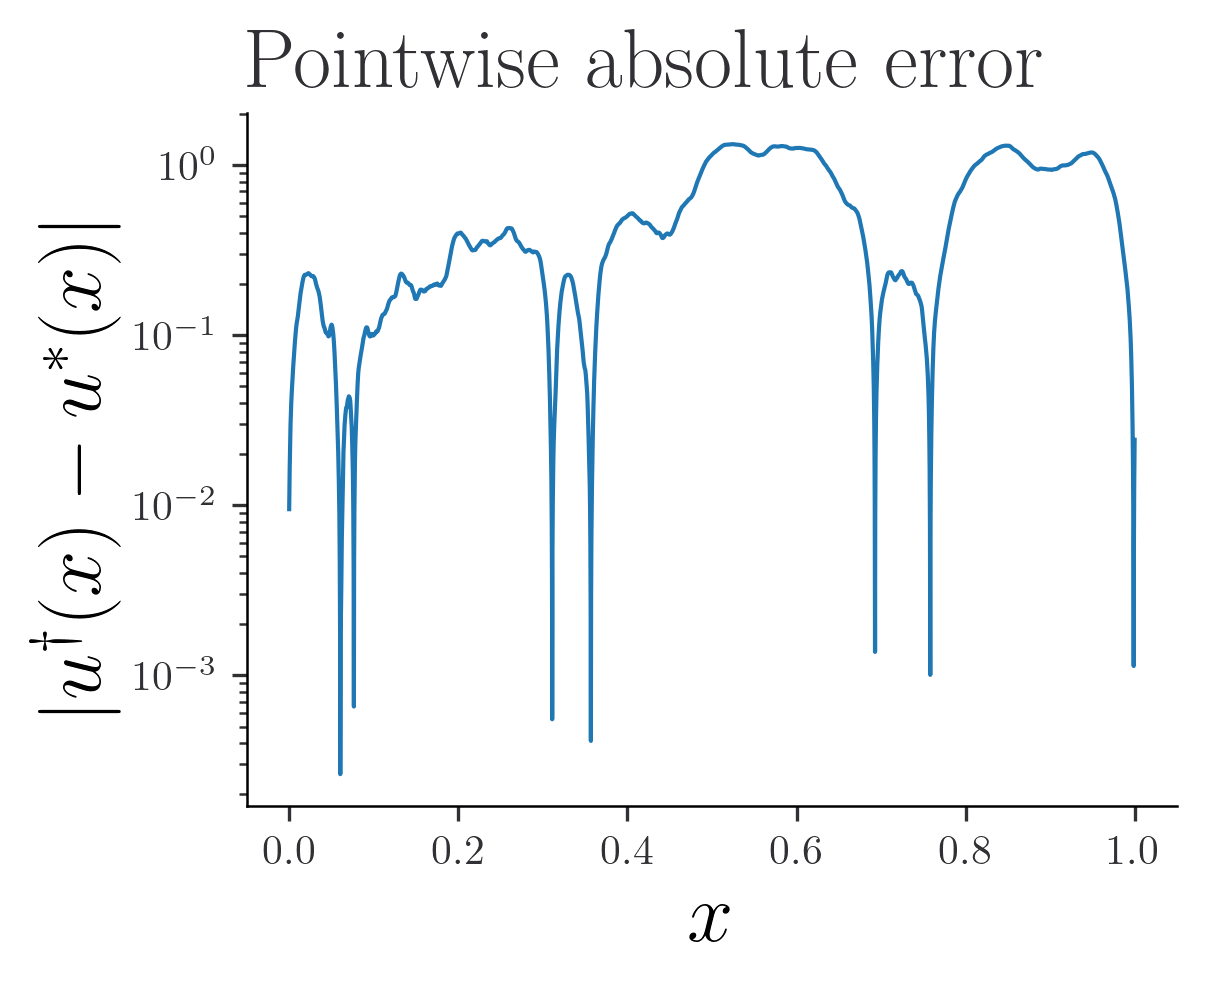

In [198]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [199]:
pred_transform = discrete_sine_transform(pred)[:-1]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


0.7134560489618341 0.5776615137176603


In [200]:
# These numbers should be close to each other
print(jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas]))
print(jnp.sqrt(jnp.mean((pred - u_values)**2)))

0.7134560444316655
0.7132051218123264


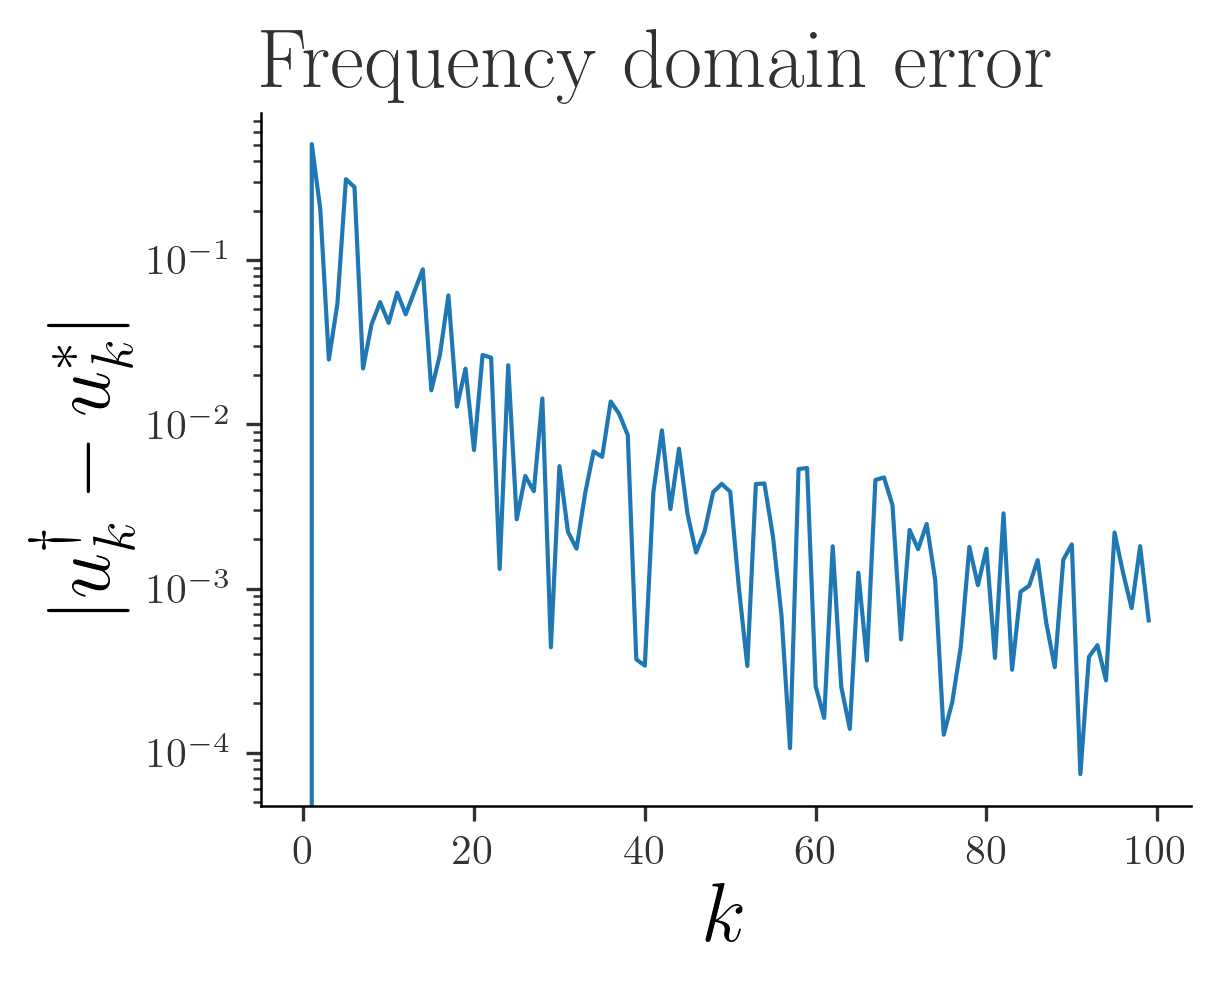

In [201]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

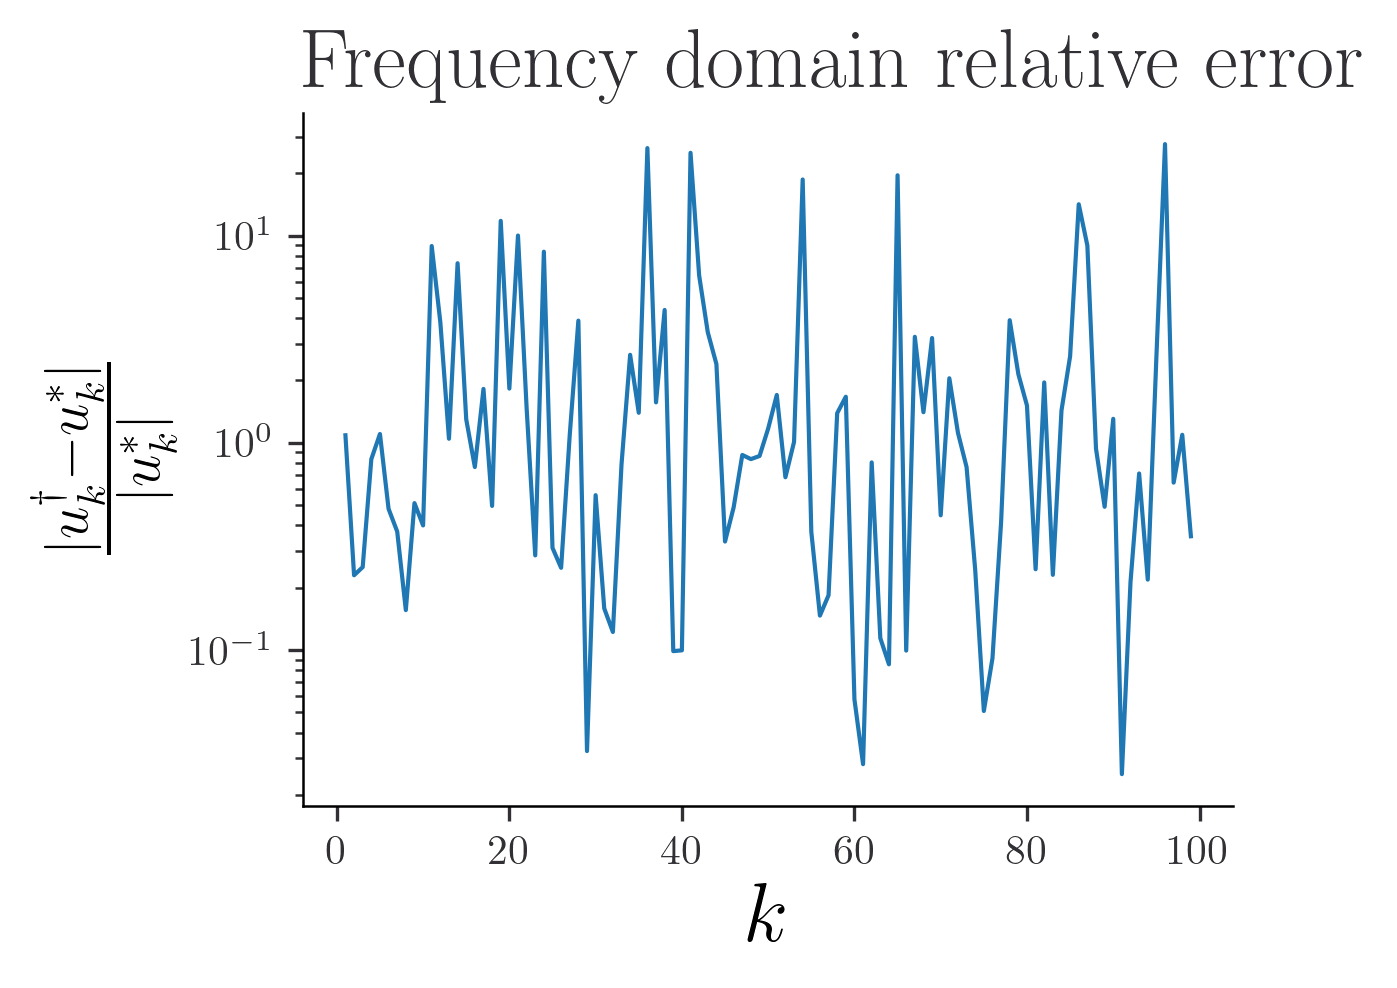

In [202]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements ($H^{-1/2}$ weighted norm) + RF

In [67]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(lower,upper, n_meas+1)
domain_measurements.shape

nugget = jnp.arange(1, n_meas+1)**(-0.5) # We weight the measurement according to the H^{-0.5} norm
print(nugget)

4096
[1.         0.70710678 0.57735027 ... 0.01562882 0.01562691 0.015625  ]


In [68]:
domain_measurements

Array([0.00000000e+00, 2.44140625e-04, 4.88281250e-04, ...,
       9.99511719e-01, 9.99755859e-01, 1.00000000e+00], dtype=float64)

In [69]:
# Draw random samples for the RF part
n_samples = 64
print('Number of samples: ', n_samples)
d_in = 1
nu = 2.5
key = random.PRNGKey(0)
key, subkey = random.split(key)
random_features = random.t(subkey, df  = nu*2, shape = (n_samples, d_in))

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))

Number of samples:  64


In [70]:
def predict_rf(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)


In [71]:
layer_sizes = [n_samples*2, 128, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict_rf, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict_rf, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = (pred_sine - f)*nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 24833 parameters in the neural network.


In [72]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

(128,) (128,)
(4097,) (4097,)
0.1277538148445983 [(Array([[-0.00438362,  0.00645612,  0.00537929, ...,  0.00569571,
         0.00548244,  0.00730371],
       [-0.00379244,  0.00563226,  0.00460895, ...,  0.00498404,
         0.00477023,  0.00636068],
       [-0.01476306,  0.02092227,  0.01890688, ...,  0.01819224,
         0.01798763,  0.02385825],
       ...,
       [-0.00593615,  0.00827012,  0.00773947, ...,  0.00714322,
         0.00714978,  0.00946507],
       [ 0.00065893, -0.00091811, -0.00085888, ..., -0.00079303,
        -0.00079372, -0.00105087],
       [ 0.00176886, -0.00246459, -0.0023056 , ..., -0.00212883,
        -0.00213068, -0.00282097]], dtype=float64), Array([-2.15221440e-02,  3.27703702e-02,  2.53821418e-02, -6.15501261e-04,
       -1.79195466e-02, -3.05516116e-02,  3.05512537e-02,  2.53663031e-03,
       -1.94472593e-03, -1.07348578e-02, -1.31476192e-02,  2.51887019e-02,
        1.10605809e-02, -1.44308397e-02,  7.23633435e-03, -3.52965294e-02,
       -1.97068275e-

In [73]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [74]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [75]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [76]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1277538
Epoch 10000, Loss: 0.0012050
Epoch 20000, Loss: 0.0012035
Epoch 30000, Loss: 0.0012060
Epoch 40000, Loss: 0.0012039
Epoch 50000, Loss: 0.0011867
Epoch 60000, Loss: 0.0011845
Epoch 70000, Loss: 0.0011787
Epoch 80000, Loss: 0.0011627
Epoch 90000, Loss: 0.0011333
Epoch 100000, Loss: 0.0011319
Epoch 110000, Loss: 0.0011259
Epoch 120000, Loss: 0.0011059
Epoch 130000, Loss: 0.0010487
Epoch 140000, Loss: 0.0010068
Epoch 150000, Loss: 0.0010140
Epoch 160000, Loss: 0.0010007
Epoch 170000, Loss: 0.0009948
Epoch 180000, Loss: 0.0009879
Epoch 190000, Loss: 0.0009700
Epoch 200000, Loss: 0.0009555
Epoch 210000, Loss: 0.0009527
Early stopping at epoch 216094


In [77]:
pred = neural_network(params, domain_finest)

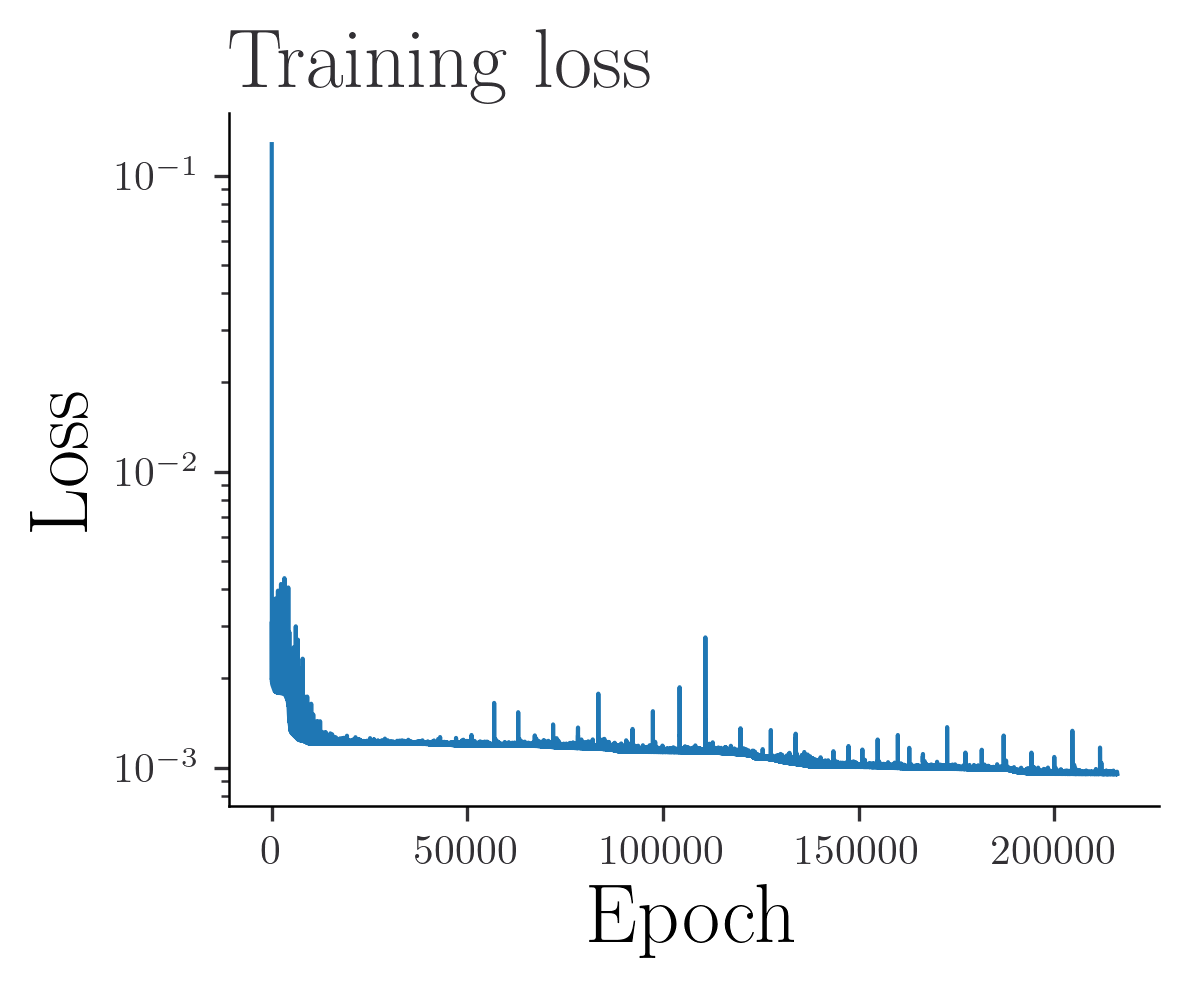

In [78]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

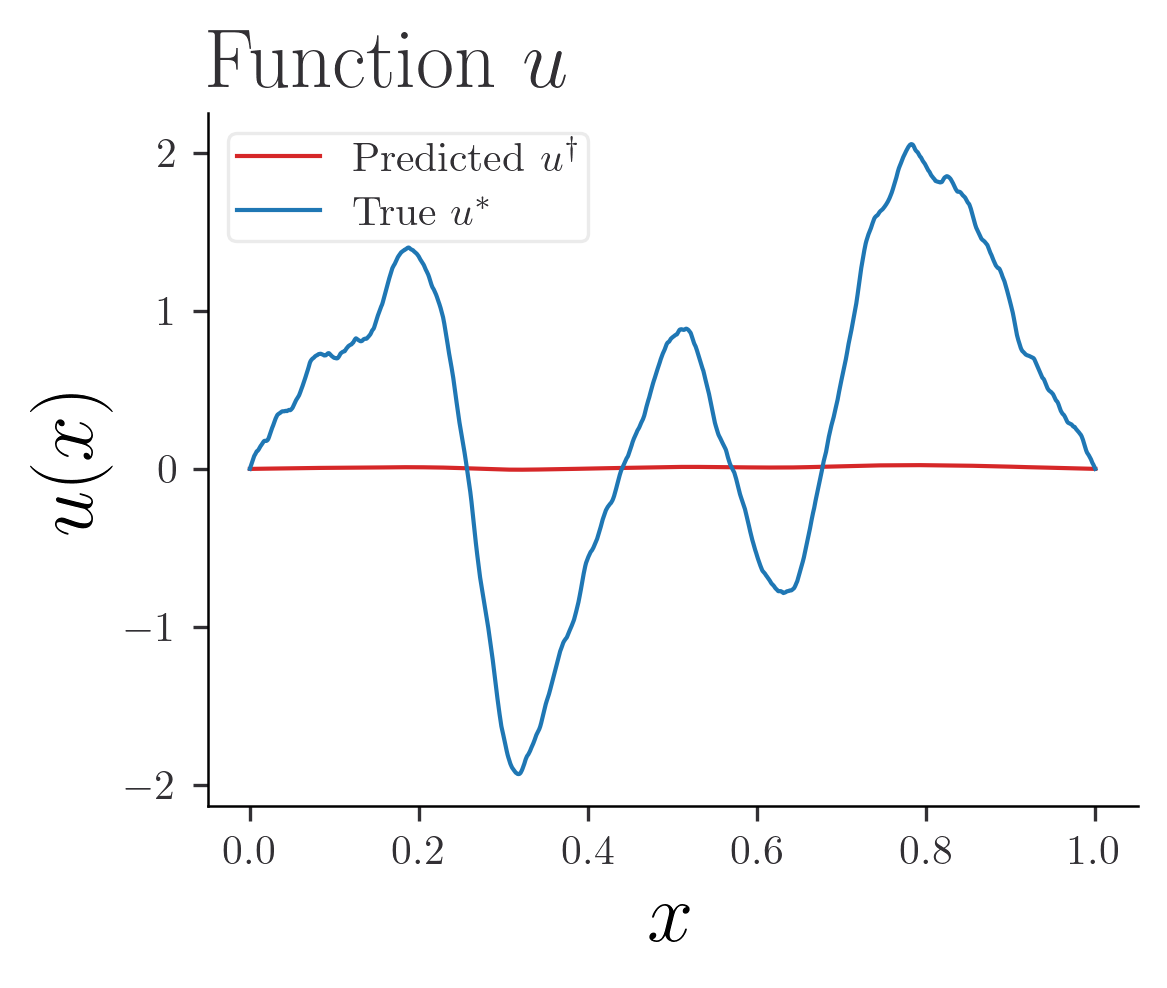

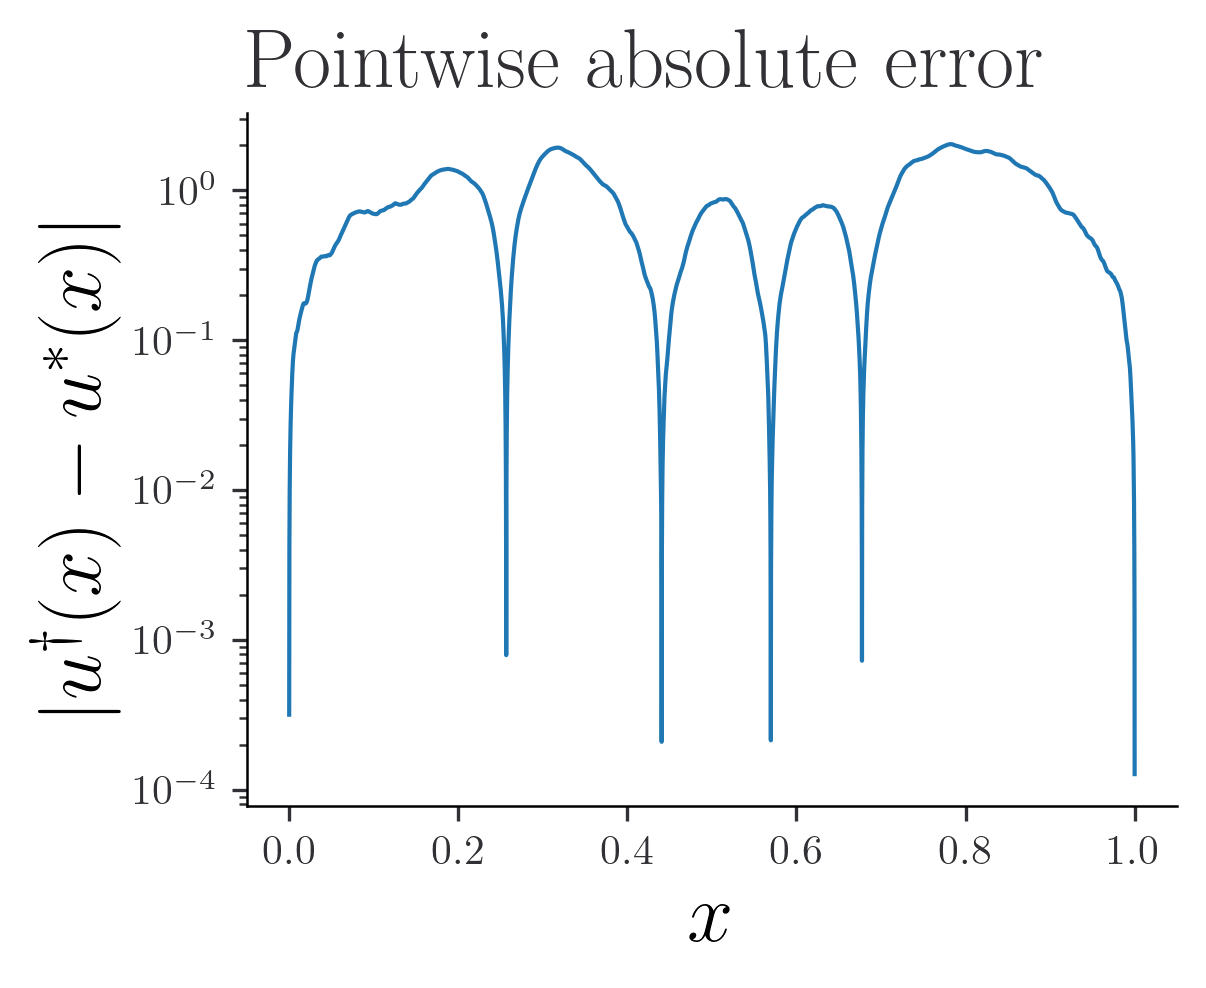

In [79]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [80]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.0319790671608065 0.9912960632950351


In [81]:
# These numbers should be close to each other
print(jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas]))
print(jnp.sqrt(jnp.mean((pred - u_values)**2)))

1.0319790669519202
1.0319138307552989


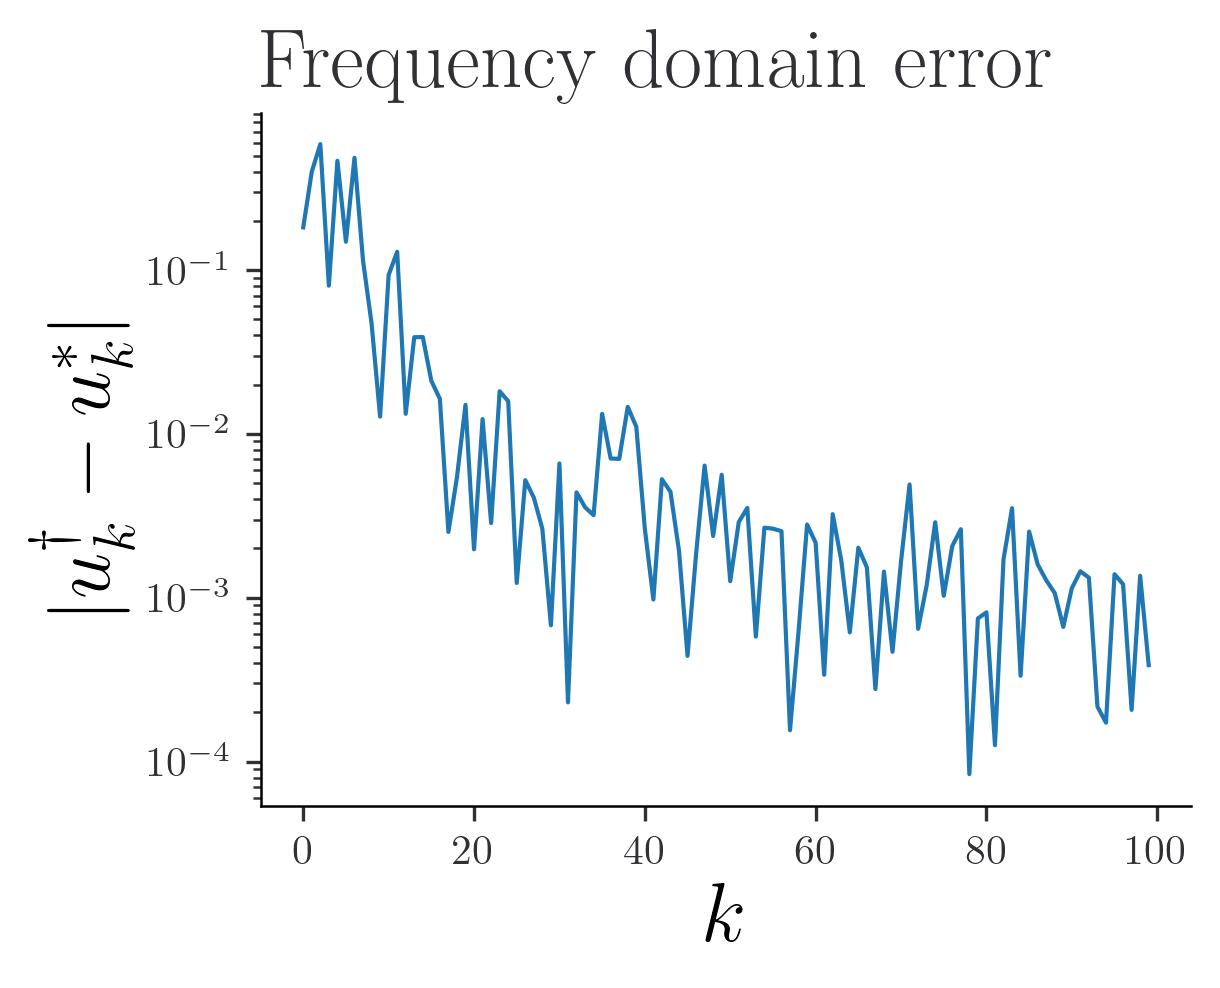

In [82]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

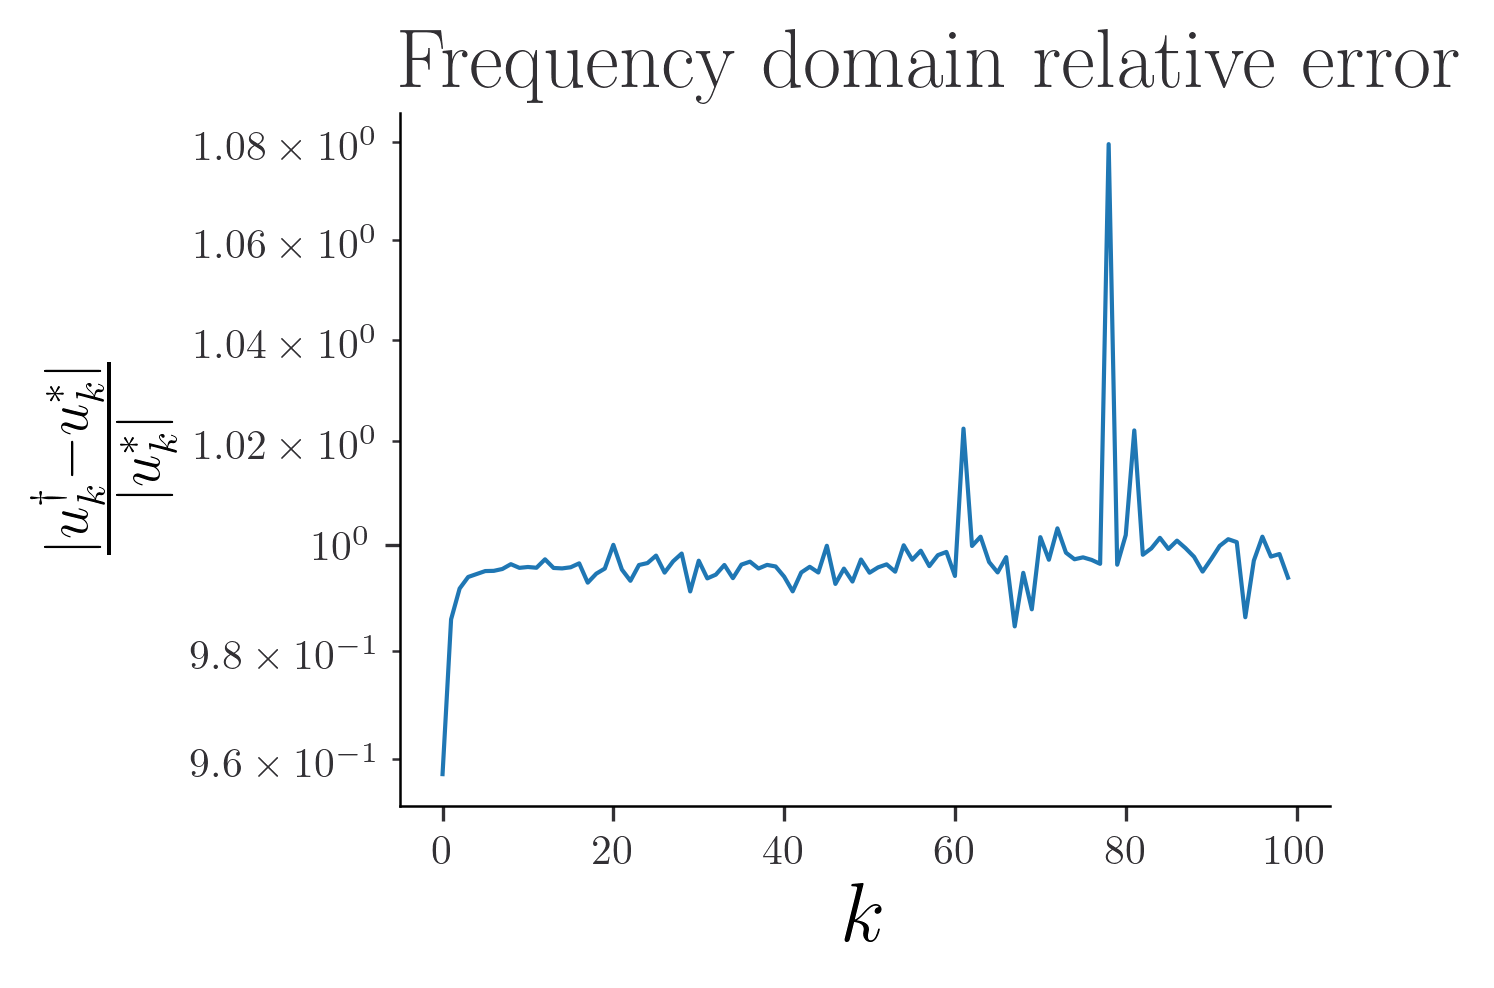

In [83]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 1024 measurements

In [ ]:
n_meas = 2**6
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

64


(65,)

In [ ]:
layer_sizes = [1, 512, 512, 512, 512, 1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)

neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = pred_sine - f

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [ ]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 1e-6)
opt_state = optimizer.init(params)

In [ ]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [ ]:
loss_hist = []
num_epochs = 2e4
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')
    loss_hist.append(loss)

Epoch 0, Loss: 0.9457
Epoch 10000, Loss: 0.2186


In [ ]:
pred = neural_network(params, domain_finest)

Text(0.0, 1.0, 'Training loss')

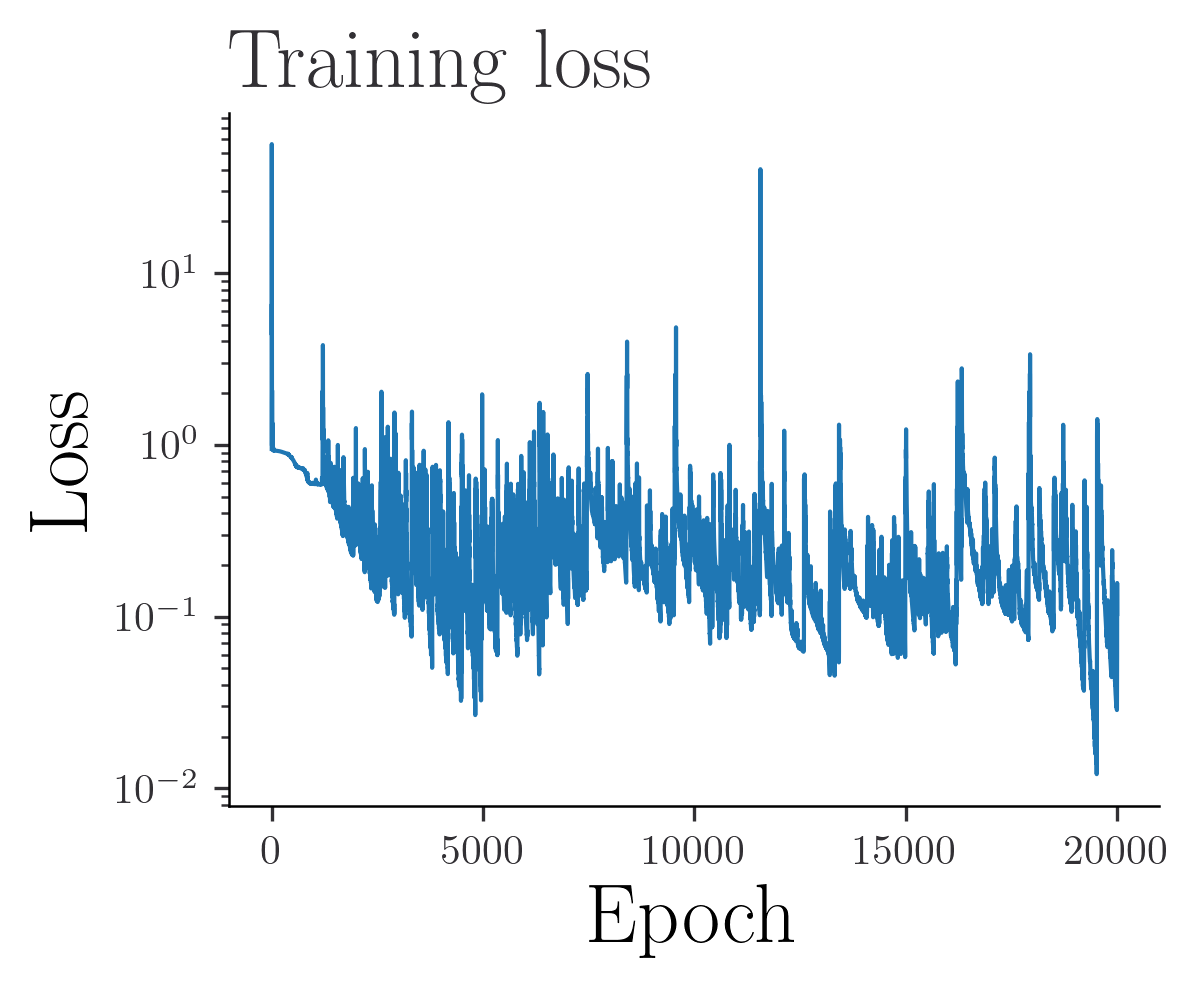

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

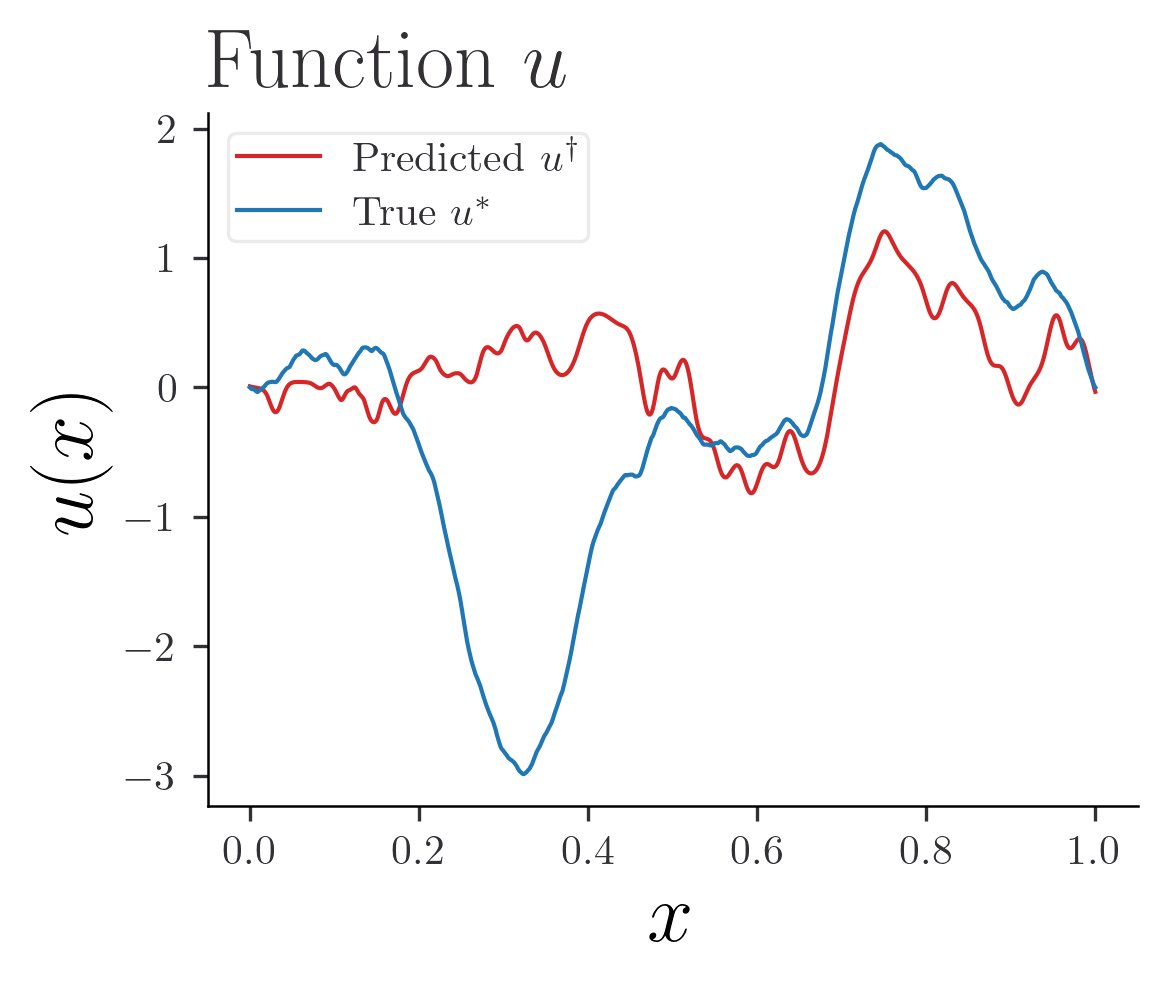

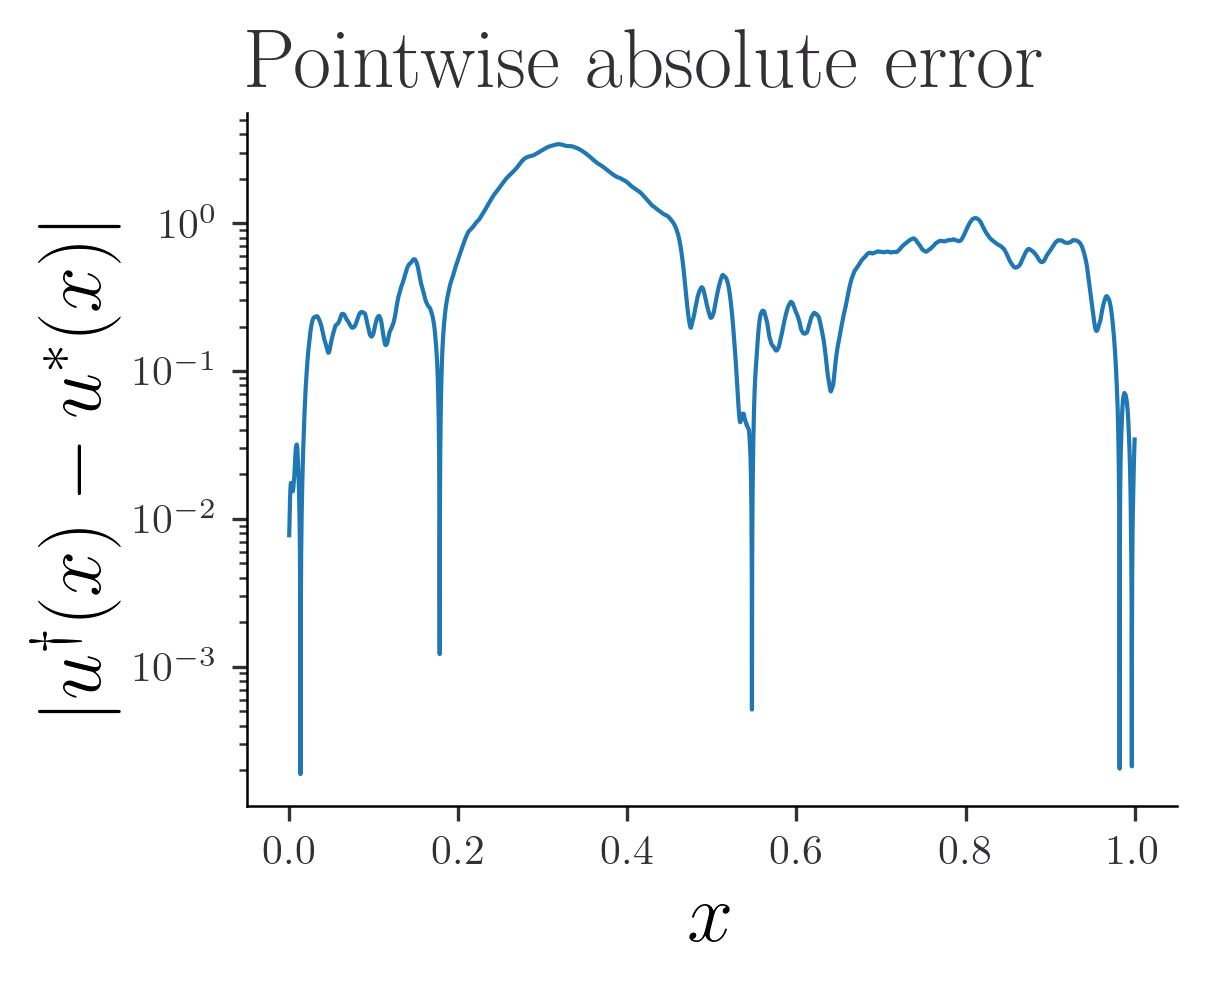

In [ ]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [ ]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.3196473674330467 1.0603984866814855


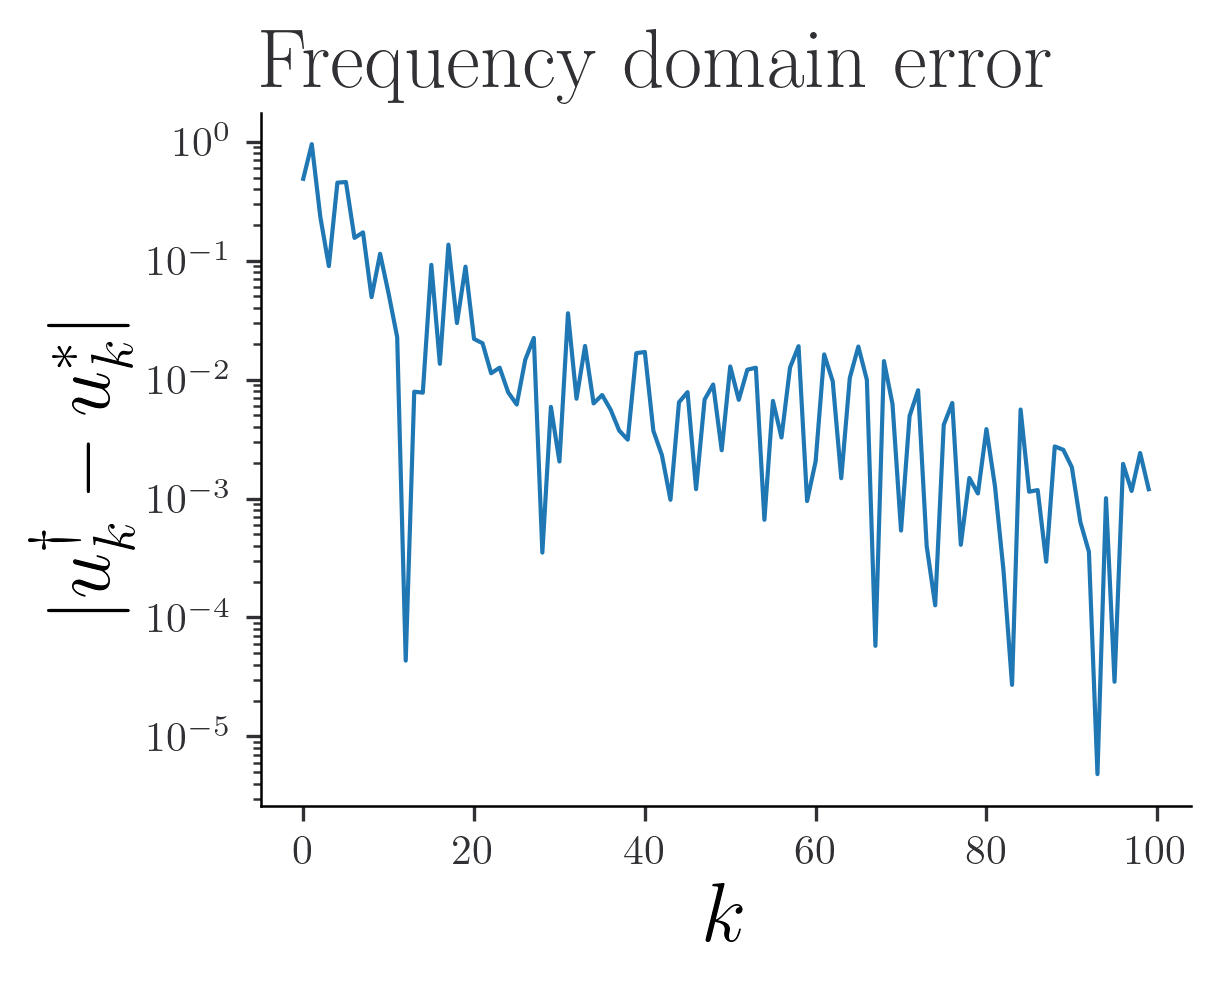

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

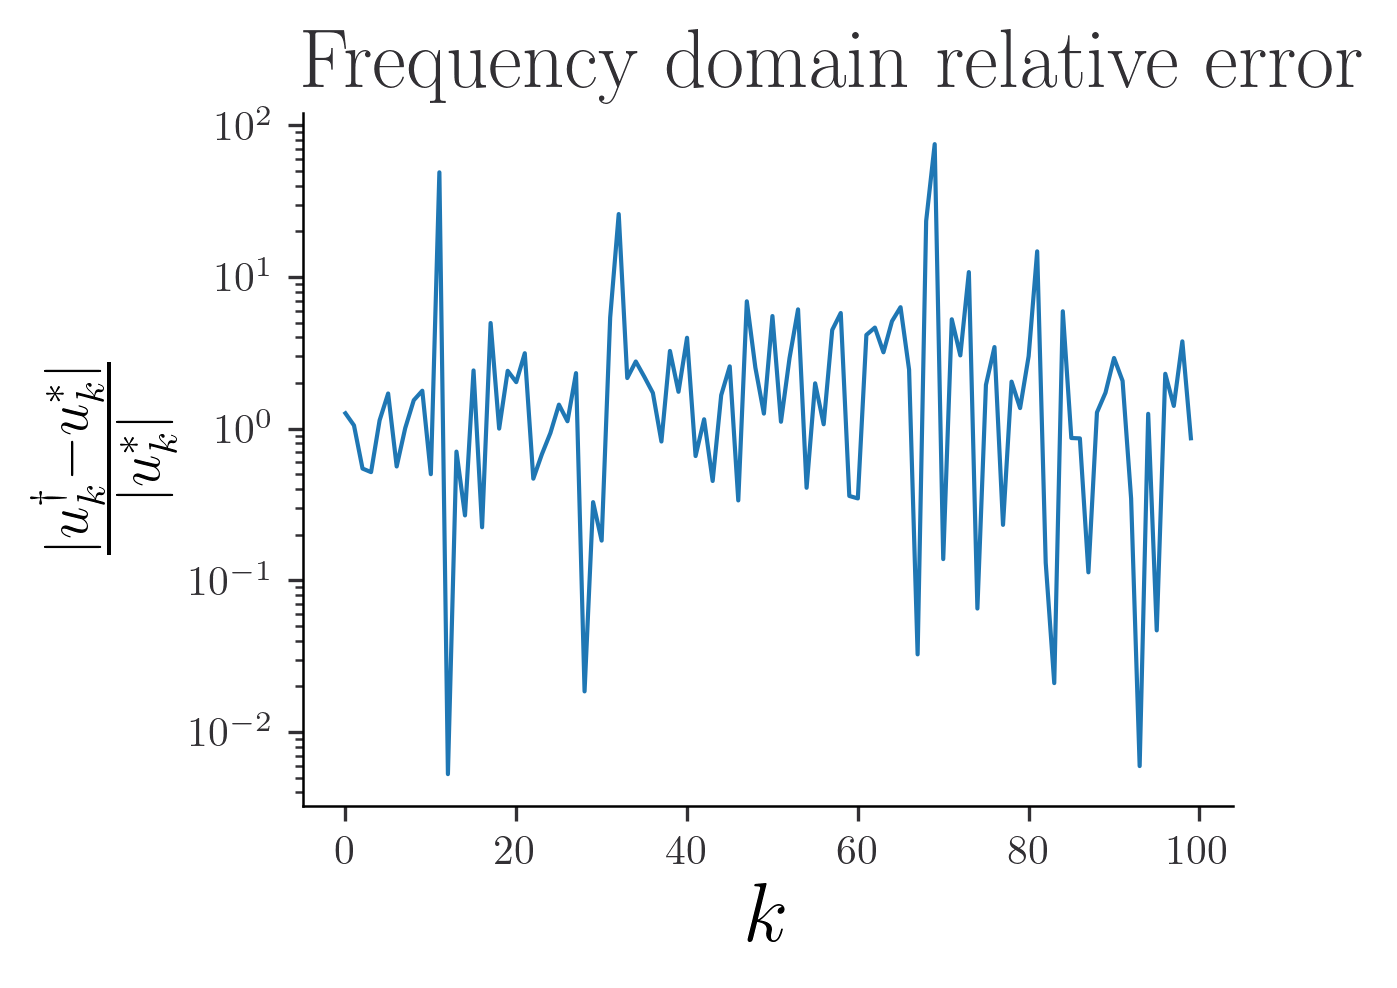

In [ ]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# High-freq PINN 4096 measurements

In [158]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

In [159]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

4096


(4097,)

In [160]:
n_samples = 1024
print('Number of samples: ', n_samples)
d_in = 1
nu = 2.5
key = random.PRNGKey(0)
key, subkey = random.split(key)
random_features = random.t(subkey, df  = nu*2, shape = (n_samples, d_in))

Number of samples:  1024


In [161]:
def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


In [162]:
feature_map(domain_measurements[50], random_features).shape

(2048,)

In [163]:

def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)


In [164]:
layer_sizes = [n_samples*2, 512, 512, 1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)

print("There are {count_parameters(params)} parameters in the neural network.")

neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

In [165]:
predict(params, domain_measurements[0]), neural_network(params, domain_measurements).shape

(Array(0.00362248, dtype=float64), (4097,))

In [166]:
# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w =1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = pred_sine - f

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [167]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, w = 0.5)
print(loss, grads)

() ()
(4097,) (4097,)
0.4924613627799138 [(Array([[-1.64587573e-05,  2.32447738e-05,  5.83477284e-06, ...,
        -5.66096126e-06,  6.53851285e-06,  1.15907157e-06],
       [ 2.31096721e-04, -3.25761541e-04, -8.21518311e-05, ...,
         7.88008630e-05, -9.03193440e-05, -1.58341064e-05],
       [-2.21186043e-04,  3.11845627e-04,  7.86006209e-05, ...,
        -7.55036733e-05,  8.66154034e-05,  1.52098143e-05],
       ...,
       [ 1.53336389e-04, -2.16168975e-04, -5.44971223e-05, ...,
         5.23196277e-05, -5.99986826e-05, -1.05299232e-05],
       [ 1.59716040e-04, -2.25163066e-04, -5.67644720e-05, ...,
         5.44965363e-05, -6.24953046e-05, -1.09680993e-05],
       [ 1.33437652e-04, -1.88115787e-04, -4.74250092e-05, ...,
         4.55297552e-05, -5.22118021e-05, -9.16327889e-06]],      dtype=float64), Array([-7.13744526e-03,  1.00629234e-02,  2.53636502e-03, -7.06400094e-04,
        4.89159317e-03, -5.24711710e-03, -1.39897309e-03, -2.13399570e-03,
        3.47854485e-03,  8.00

In [168]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [171]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, w = 0.1)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [172]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [173]:
loss_hist = []
num_epochs = 1e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1003
Early stopping at epoch 9591


In [174]:
pred = neural_network(params, domain_finest)

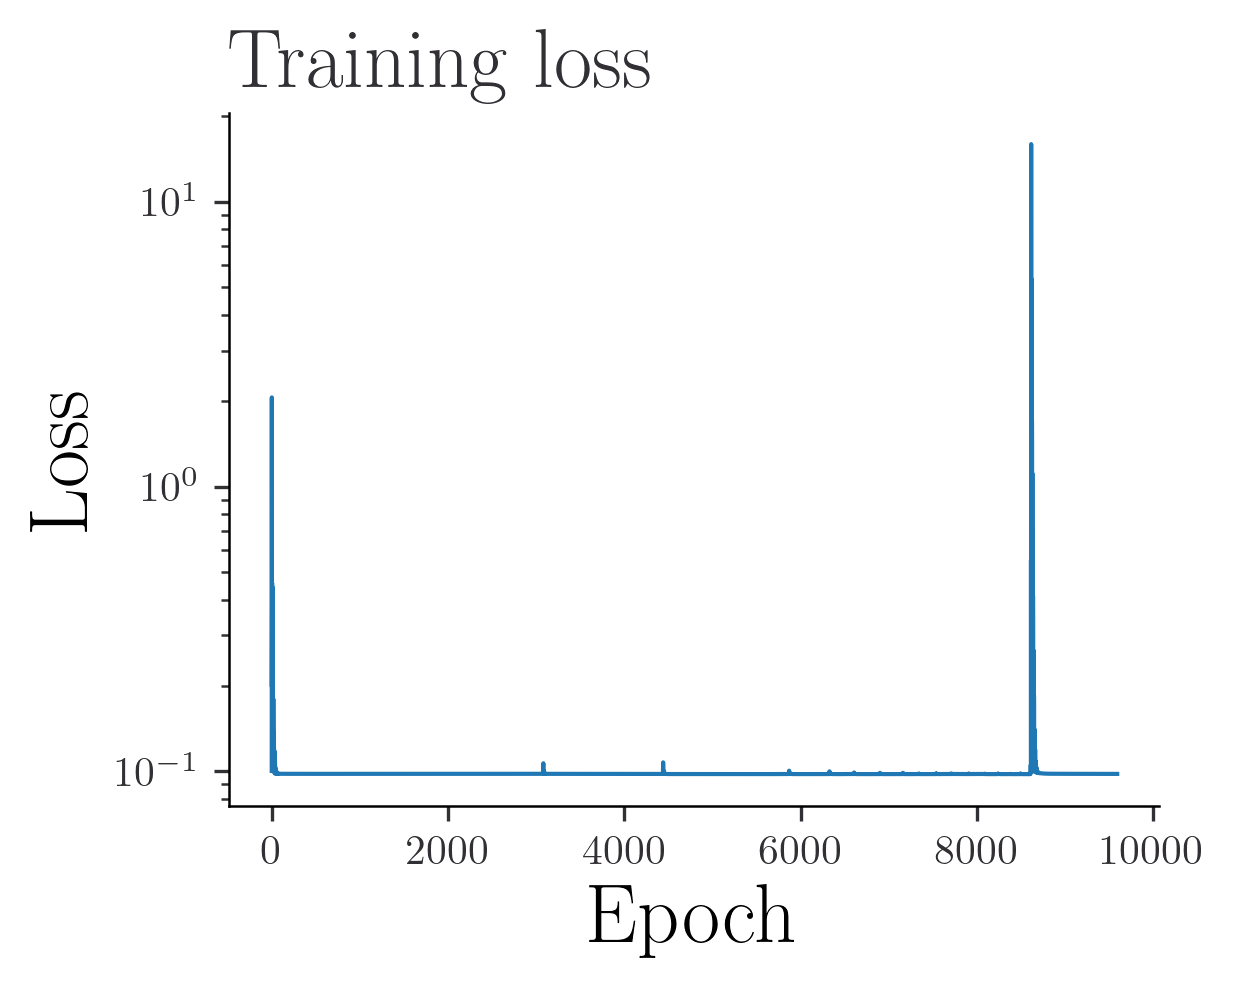

In [175]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

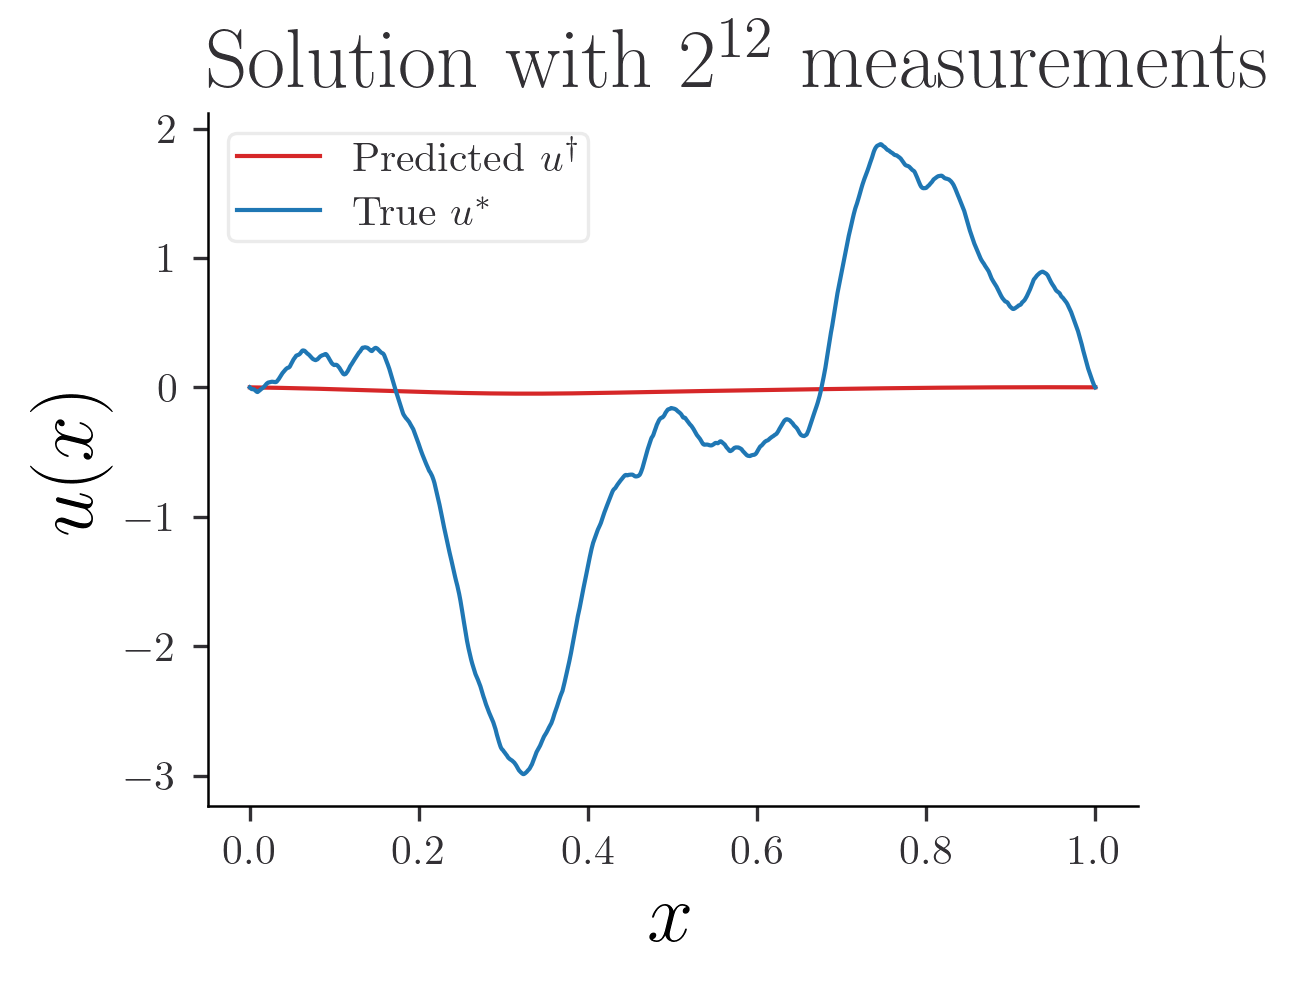

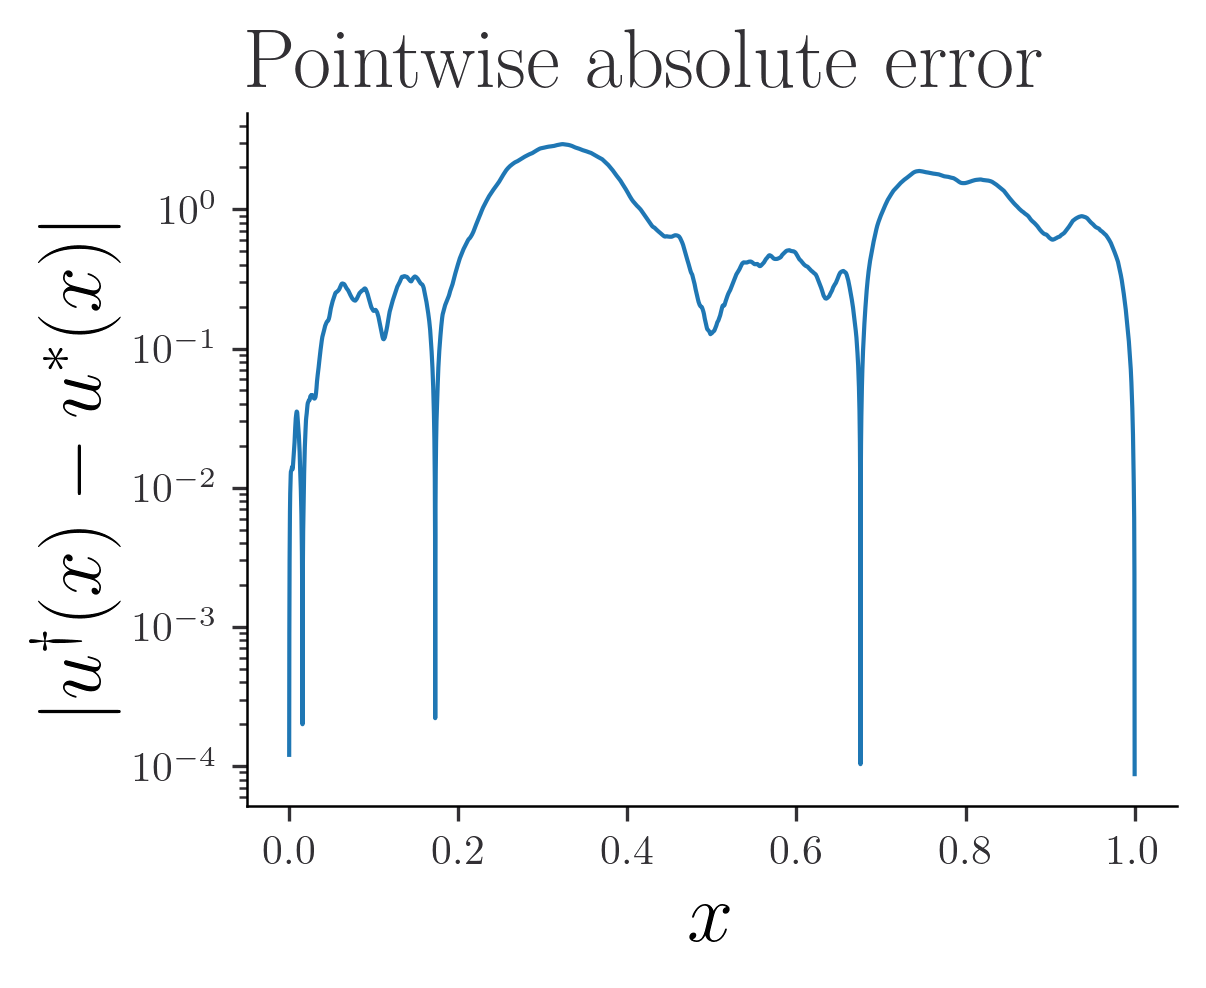

In [180]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
#plt.title(r"Function $u$")
plt.title(r"Solution with $2^{"+str(12)+"}$ measurements")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [181]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.2456186385822197 1.0009129347214436


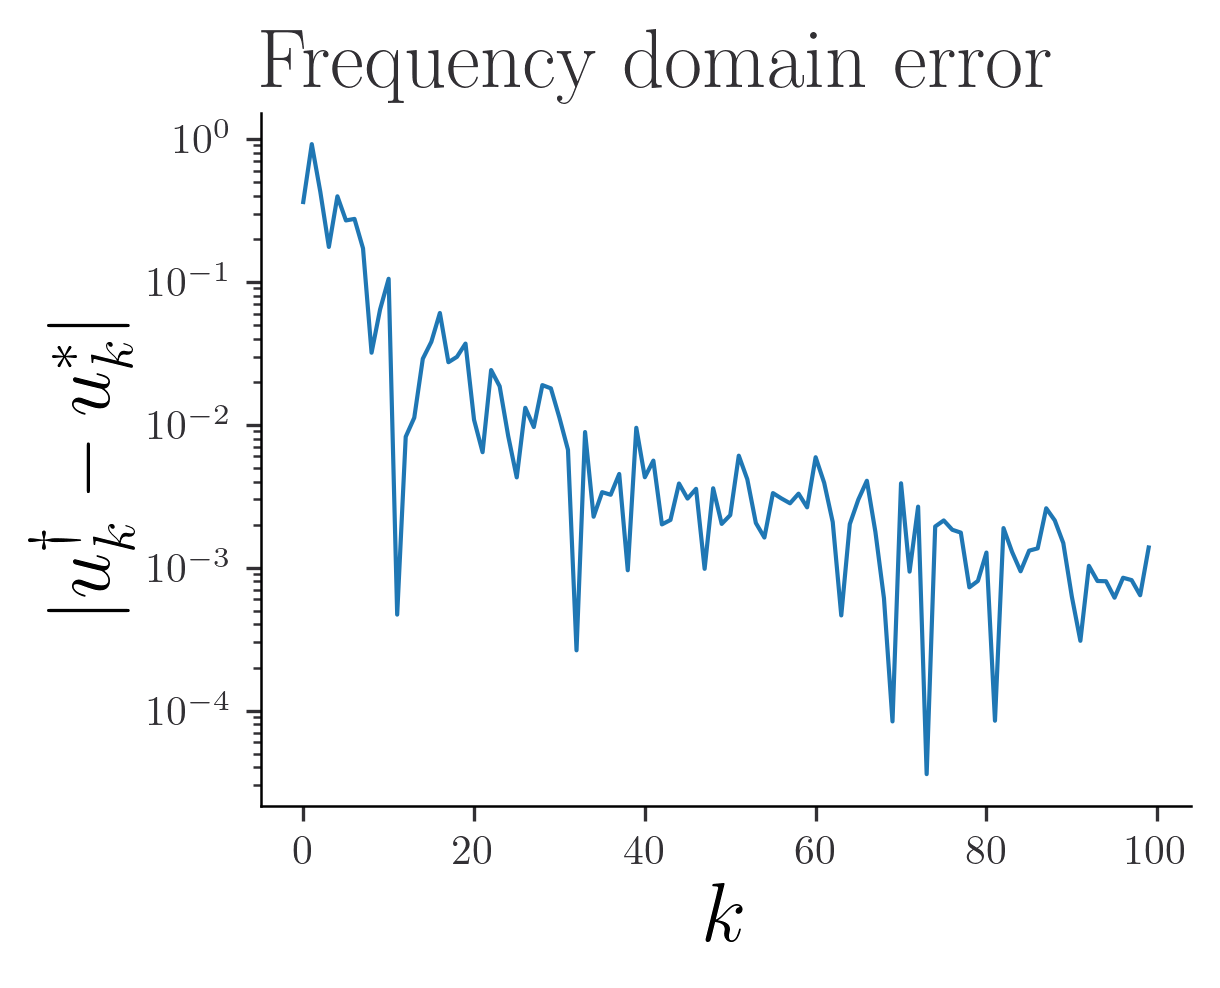

In [182]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

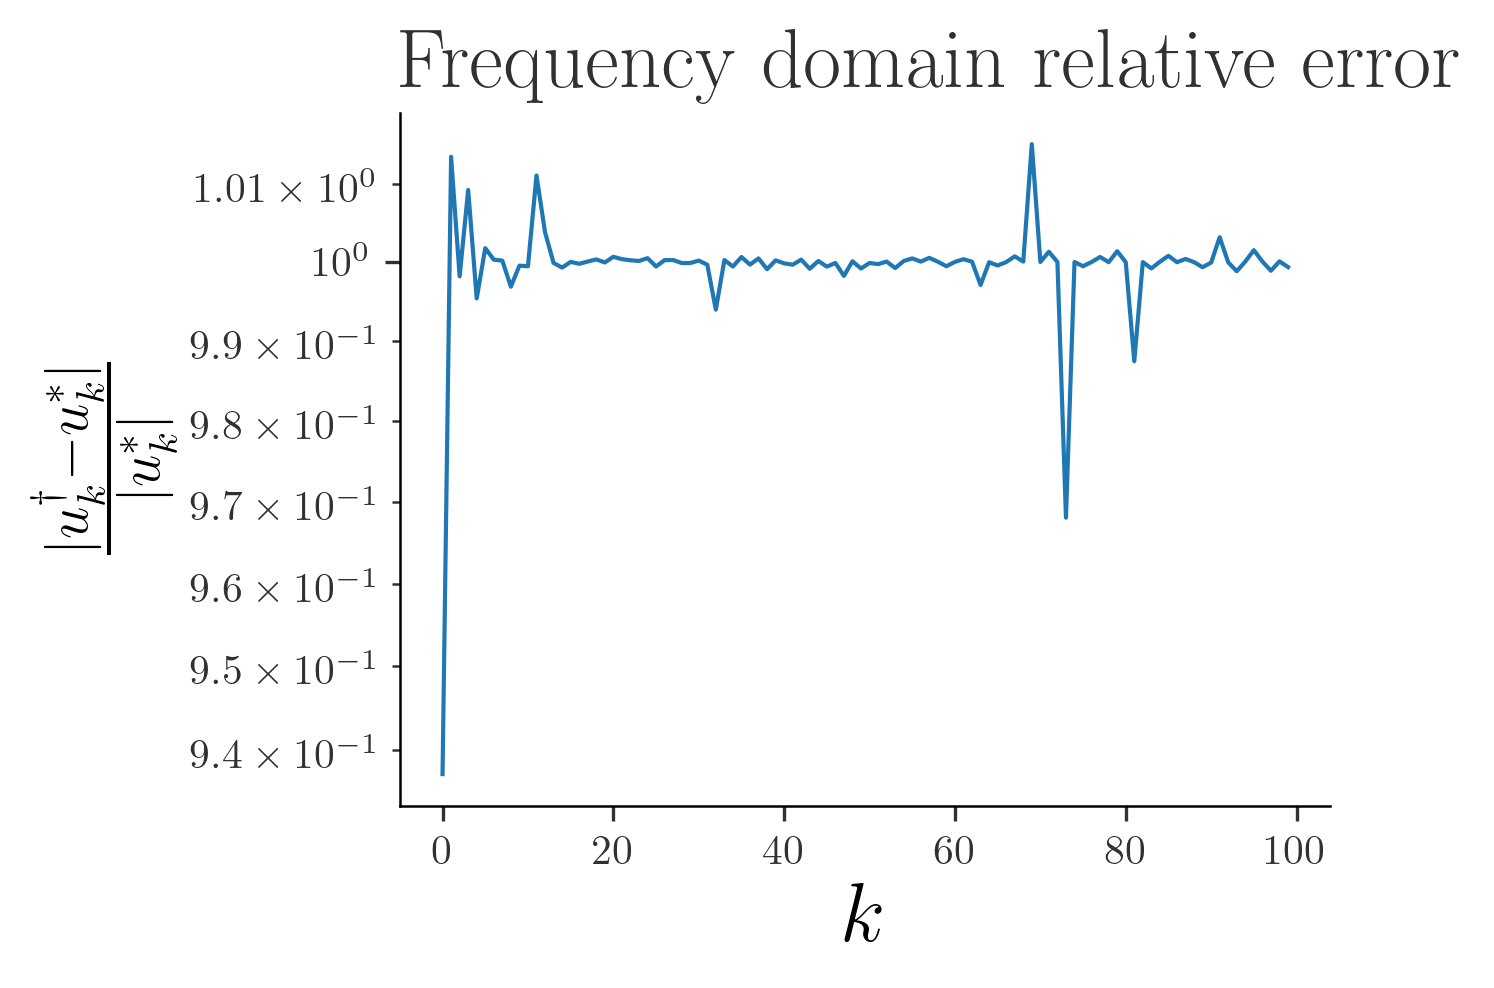

In [183]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()